Import important parameter

In [30]:
inputsize = 13
e = 0.1

Import Package

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [32]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [33]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

Local DMM on fine grid

In [5]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=2)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.6711454985407406
Iteration 200/4000
Upper bound estimation = 0.6495355024035463
Iteration 300/4000
Upper bound estimation = 0.6478063256956662
Iteration 400/4000
Upper bound estimation = 0.6464155620454873
Iteration 500/4000
Upper bound estimation = 0.6310700814797026
Iteration 600/4000
Upper bound estimation = 0.617258688336023
Iteration 700/4000
Upper bound estimation = 0.5815379657112147
Iteration 800/4000
Upper bound estimation = 0.5656493087097582
Iteration 900/4000
Upper bound estimation = 0.5478410436996699
Iteration 1000/4000
Upper bound estimation = 0.5157092632932191
Iteration 1100/4000
Upper bound estimation = 0.513425614752417
Iteration 1200/4000
Upper bound estimation = 0.4937866831835363
Iteration 1300/4000
Upper bound estimation = 0.46527169066668217
Iteration 1400/4000
Upper bound estimation = 0.44957472389102693
Iteration 1500/4000
Upper bound estimation = 0.42010949860843994
Iteration 1600/4000
Upper bound estimation = 0.3

In [6]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.1008287071386727


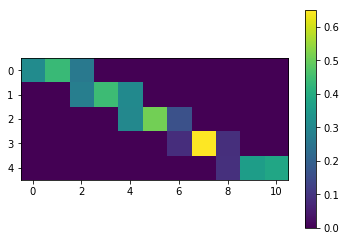

In [7]:
localR = opt_par[1][0]
LOCALR = np.zeros([outputsize-1,inputsize-2])
for i in range(outputsize-1):
    C = localR[i][:]
    for l in range(3):
        LOCALR[i][2*i+l] = C[l]
        
        
plt.imshow(LOCALR)
plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


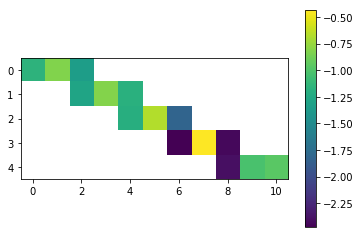

In [8]:
plt.imshow(np.log(np.abs(LOCALR)))
plt.colorbar()

In [9]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11667031280695284
L = 0.03
rho = 0.1173023299418299
L = 0.04
rho = 0.118195184270311
L = 0.05
rho = 0.11924067503501776
L = 0.060000000000000005
rho = 0.12037329189219416
L = 0.07
rho = 0.12155675177347704
L = 0.08
rho = 0.12277115663653065
L = 0.09
rho = 0.1240054639482385
L = 0.09999999999999999
rho = 0.1252535449043703
L = 0.10999999999999999
rho = 0.12651215035996777
L = 0.11999999999999998
rho = 0.12777985131729333
L = 0.12999999999999998
rho = 0.1290564881204442
L = 0.13999999999999999
rho = 0.13034289699445156
L = 0.15
rho = 0.13164079492499123
L = 0.16
rho = 0.13295275641176563
L = 0.17
rho = 0.13428223766364963
L = 0.18000000000000002
rho = 0.1356336088402513
L = 0.19000000000000003
rho = 0.13701215024864358
L = 0.20000000000000004
rho = 0.13842396049880978
L = 0.21000000000000005
rho = 0.13987572262843012
L = 0.22000000000000006
rho = 0.14137429027951245
L = 0.23000000000000007
rho = 0.14292610032606612
L = 0.24000000000000007
rho = 0.14

the 63 steps
rho = 0.3106723487603806
the 64 steps
rho = 0.3106686311251092
the 65 steps
rho = 0.3106649138027275
the 66 steps
rho = 0.3106611967931848
the 67 steps
rho = 0.31065748009643196
the 68 steps
rho = 0.310653763712419
the 69 steps
rho = 0.31065004764109505
the 70 steps
rho = 0.31064633188241053
the 71 steps
rho = 0.31064261643631536
the 72 steps
rho = 0.3106389013027594
the 73 steps
rho = 0.31063518648169247
the 74 steps
rho = 0.3106314719730657
the 75 steps
rho = 0.3106277577768271
the 76 steps
rho = 0.310624043892928
the 77 steps
rho = 0.310620330321318
the 78 steps
rho = 0.3106166170619476
the 79 steps
rho = 0.3106129041147666
the 80 steps
rho = 0.3106091914797252
the 81 steps
rho = 0.3106054791567724
the 82 steps
rho = 0.3106017671458593
the 83 steps
rho = 0.31059805544693575
the 84 steps
rho = 0.31059434405995184
the 85 steps
rho = 0.3105906329848577
the 86 steps
rho = 0.3105869222216036
the 87 steps
rho = 0.310583211770139
the 88 steps
rho = 0.31057950163041426
the 89 s

the 231 steps
rho = 0.3100521366752702
the 232 steps
rho = 0.31004847091018295
the 233 steps
rho = 0.3100448054497042
the 234 steps
rho = 0.31004114029378427
the 235 steps
rho = 0.3100374754423755
the 236 steps
rho = 0.31003381089542864
the 237 steps
rho = 0.3100301466528952
the 238 steps
rho = 0.3100264827147277
the 239 steps
rho = 0.31002281908087687
the 240 steps
rho = 0.3100191557512948
the 241 steps
rho = 0.3100154927259325
the 242 steps
rho = 0.31001183000474164
the 243 steps
rho = 0.3100081675876741
the 244 steps
rho = 0.31000450547468117
the 245 steps
rho = 0.31000084366571473
the 246 steps
rho = 0.30999718216072636
the 247 steps
rho = 0.30999352095966737
the 248 steps
rho = 0.30998986006248963
the 249 steps
rho = 0.3099861994691449
the 250 steps
rho = 0.3099825391795848
the 251 steps
rho = 0.3099788791937606
the 252 steps
rho = 0.3099752195116247
the 253 steps
rho = 0.30997156013312765
the 254 steps
rho = 0.3099679010582221
the 255 steps
rho = 0.30996424228685954
the 256 steps

the 401 steps
rho = 0.3094332935976687
the 402 steps
rho = 0.309429678926666
the 403 steps
rho = 0.3094260645521584
the 404 steps
rho = 0.3094224504741006
the 405 steps
rho = 0.30941883669244474
the 406 steps
rho = 0.3094152232071433
the 407 steps
rho = 0.3094116100181505
the 408 steps
rho = 0.30940799712541894
the 409 steps
rho = 0.309404384528902
the 410 steps
rho = 0.30940077222855183
the 411 steps
rho = 0.3093971602243235
the 412 steps
rho = 0.30939354851616846
the 413 steps
rho = 0.30938993710404006
the 414 steps
rho = 0.309386325987892
the 415 steps
rho = 0.30938271516767724
the 416 steps
rho = 0.30937910464334895
the 417 steps
rho = 0.3093754944148604
the 418 steps
rho = 0.3093718844821645
the 419 steps
rho = 0.30936827484521456
the 420 steps
rho = 0.30936466550396396
the 421 steps
rho = 0.3093610564583662
the 422 steps
rho = 0.3093574477083741
the 423 steps
rho = 0.3093538392539399
the 424 steps
rho = 0.3093502310950196
the 425 steps
rho = 0.3093466232315638
the 426 steps
rho =

the 578 steps
rho = 0.30879807276555976
the 579 steps
rho = 0.30879450985153456
the 580 steps
rho = 0.3087909472258373
the 581 steps
rho = 0.3087873848884248
the 582 steps
rho = 0.3087838228392513
the 583 steps
rho = 0.3087802610782714
the 584 steps
rho = 0.308776699605439
the 585 steps
rho = 0.3087731384207092
the 586 steps
rho = 0.3087695775240383
the 587 steps
rho = 0.30876601691537864
the 588 steps
rho = 0.30876245659468615
the 589 steps
rho = 0.3087588965619152
the 590 steps
rho = 0.30875533681702105
the 591 steps
rho = 0.30875177735995823
the 592 steps
rho = 0.30874821819068043
the 593 steps
rho = 0.3087446593091443
the 594 steps
rho = 0.3087411007153031
the 595 steps
rho = 0.30873754240911233
the 596 steps
rho = 0.3087339843905266
the 597 steps
rho = 0.3087304266595003
the 598 steps
rho = 0.3087268692159891
the 599 steps
rho = 0.3087233120599474
the 600 steps
rho = 0.3087197551913301
the 601 steps
rho = 0.3087161986100913
the 602 steps
rho = 0.3087126423161868
the 603 steps
rho 

the 753 steps
rho = 0.30817891314918144
the 754 steps
rho = 0.30817540001017546
the 755 steps
rho = 0.3081718871516971
the 756 steps
rho = 0.308168374573703
the 757 steps
rho = 0.3081648622761488
the 758 steps
rho = 0.30816135025899105
the 759 steps
rho = 0.30815783852218587
the 760 steps
rho = 0.3081543270656898
the 761 steps
rho = 0.30815081588945864
the 762 steps
rho = 0.3081473049934486
the 763 steps
rho = 0.30814379437761596
the 764 steps
rho = 0.3081402840419173
the 765 steps
rho = 0.3081367739863081
the 766 steps
rho = 0.3081332642107462
the 767 steps
rho = 0.30812975471518633
the 768 steps
rho = 0.3081262454995851
the 769 steps
rho = 0.30812273656389944
the 770 steps
rho = 0.30811922790808477
the 771 steps
rho = 0.30811571953209815
the 772 steps
rho = 0.30811221143589573
the 773 steps
rho = 0.3081087036194334
the 774 steps
rho = 0.3081051960826675
the 775 steps
rho = 0.30810168882555494
the 776 steps
rho = 0.308098181848052
the 777 steps
rho = 0.30809467515011507
the 778 steps


the 928 steps
rho = 0.3075683467101717
the 929 steps
rho = 0.3075648820038858
the 930 steps
rho = 0.30756141757058864
the 931 steps
rho = 0.30755795341023795
the 932 steps
rho = 0.3075544895227923
the 933 steps
rho = 0.30755102590820854
the 934 steps
rho = 0.3075475625664442
the 935 steps
rho = 0.3075440994974578
the 936 steps
rho = 0.30754063670120596
the 937 steps
rho = 0.3075371741776472
the 938 steps
rho = 0.30753371192673906
the 939 steps
rho = 0.30753024994843947
the 940 steps
rho = 0.3075267882427055
the 941 steps
rho = 0.30752332680949573
the 942 steps
rho = 0.3075198656487673
the 943 steps
rho = 0.3075164047604783
the 944 steps
rho = 0.3075129441445862
the 945 steps
rho = 0.30750948380104953
the 946 steps
rho = 0.30750602372982483
the 947 steps
rho = 0.30750256393087083
the 948 steps
rho = 0.30749910440414546
the 949 steps
rho = 0.30749564514960565
the 950 steps
rho = 0.3074921861672095
the 951 steps
rho = 0.3074887274569155
the 952 steps
rho = 0.3074852690186806
the 953 steps

the 1105 steps
rho = 0.3069593076333854
the 1106 steps
rho = 0.3069558905942029
the 1107 steps
rho = 0.3069524738206443
the 1108 steps
rho = 0.30694905731266786
the 1109 steps
rho = 0.30694564107023276
the 1110 steps
rho = 0.3069422250932986
the 1111 steps
rho = 0.30693880938182494
the 1112 steps
rho = 0.30693539393576924
the 1113 steps
rho = 0.306931978755093
the 1114 steps
rho = 0.3069285638397537
the 1115 steps
rho = 0.3069251491897102
the 1116 steps
rho = 0.3069217348049234
the 1117 steps
rho = 0.30691832068535124
the 1118 steps
rho = 0.3069149068309527
the 1119 steps
rho = 0.30691149324168787
the 1120 steps
rho = 0.30690807991751584
the 1121 steps
rho = 0.30690466685839524
the 1122 steps
rho = 0.3069012540642853
the 1123 steps
rho = 0.30689784153514604
the 1124 steps
rho = 0.3068944292709362
the 1125 steps
rho = 0.30689101727161433
the 1126 steps
rho = 0.3068876055371412
the 1127 steps
rho = 0.3068841940674747
the 1128 steps
rho = 0.3068807828625749
the 1129 steps
rho = 0.30687737

the 1281 steps
rho = 0.3063619631256526
the 1282 steps
rho = 0.3063585922136478
the 1283 steps
rho = 0.30635522156019274
the 1284 steps
rho = 0.30635185116524827
the 1285 steps
rho = 0.30634848102877443
the 1286 steps
rho = 0.30634511115073176
the 1287 steps
rho = 0.30634174153108124
the 1288 steps
rho = 0.30633837216978277
the 1289 steps
rho = 0.30633500306679756
the 1290 steps
rho = 0.3063316342220857
the 1291 steps
rho = 0.3063282656356083
the 1292 steps
rho = 0.30632489730732465
the 1293 steps
rho = 0.3063215292371964
the 1294 steps
rho = 0.3063181614251842
the 1295 steps
rho = 0.30631479387124844
the 1296 steps
rho = 0.3063114265753492
the 1297 steps
rho = 0.3063080595374477
the 1298 steps
rho = 0.3063046927575048
the 1299 steps
rho = 0.30630132623548056
the 1300 steps
rho = 0.30629795997133535
the 1301 steps
rho = 0.3062945939650307
the 1302 steps
rho = 0.306291228216527
the 1303 steps
rho = 0.3062878627257838
the 1304 steps
rho = 0.3062844974927634
the 1305 steps
rho = 0.3062811

the 1457 steps
rho = 0.3057726293028529
the 1458 steps
rho = 0.3057693032943131
the 1459 steps
rho = 0.3057659775374904
the 1460 steps
rho = 0.30576265203234704
the 1461 steps
rho = 0.30575932677884493
the 1462 steps
rho = 0.3057560017769465
the 1463 steps
rho = 0.3057526770266129
the 1464 steps
rho = 0.30574935252780605
the 1465 steps
rho = 0.30574602828048825
the 1466 steps
rho = 0.30574270428462125
the 1467 steps
rho = 0.30573938054016686
the 1468 steps
rho = 0.3057360570470877
the 1469 steps
rho = 0.3057327338053441
the 1470 steps
rho = 0.30572941081489935
the 1471 steps
rho = 0.30572608807571483
the 1472 steps
rho = 0.305722765587752
the 1473 steps
rho = 0.30571944335097495
the 1474 steps
rho = 0.3057161213653432
the 1475 steps
rho = 0.30571279963082015
the 1476 steps
rho = 0.30570947814736643
the 1477 steps
rho = 0.30570615691494546
the 1478 steps
rho = 0.3057028359335187
the 1479 steps
rho = 0.3056995152030479
the 1480 steps
rho = 0.3056961947234959
the 1481 steps
rho = 0.305692

the 1633 steps
rho = 0.3051910944694091
the 1634 steps
rho = 0.3051878121824147
the 1635 steps
rho = 0.30518453014053964
the 1636 steps
rho = 0.3051812483437466
the 1637 steps
rho = 0.3051779667919987
the 1638 steps
rho = 0.30517468548525917
the 1639 steps
rho = 0.3051714044234907
the 1640 steps
rho = 0.3051681236066578
the 1641 steps
rho = 0.30516484303472224
the 1642 steps
rho = 0.3051615627076481
the 1643 steps
rho = 0.3051582826253981
the 1644 steps
rho = 0.30515500278793595
the 1645 steps
rho = 0.3051517231952244
the 1646 steps
rho = 0.30514844384722667
the 1647 steps
rho = 0.3051451647439065
the 1648 steps
rho = 0.3051418858852266
the 1649 steps
rho = 0.3051386072711506
the 1650 steps
rho = 0.30513532890164174
the 1651 steps
rho = 0.30513205077666294
the 1652 steps
rho = 0.3051287728961781
the 1653 steps
rho = 0.30512549526014954
the 1654 steps
rho = 0.3051222178685411
the 1655 steps
rho = 0.3051189407213165
the 1656 steps
rho = 0.3051156638184384
the 1657 steps
rho = 0.305112387

the 1810 steps
rho = 0.304613914454421
the 1811 steps
rho = 0.3046106749861772
the 1812 steps
rho = 0.3046074357566438
the 1813 steps
rho = 0.3046041967657844
the 1814 steps
rho = 0.3046009580135634
the 1815 steps
rho = 0.3045977194999463
the 1816 steps
rho = 0.3045944812248967
the 1817 steps
rho = 0.30459124318837916
the 1818 steps
rho = 0.3045880053903582
the 1819 steps
rho = 0.3045847678307981
the 1820 steps
rho = 0.30458153050966363
the 1821 steps
rho = 0.30457829342691956
the 1822 steps
rho = 0.30457505658252926
the 1823 steps
rho = 0.3045718199764582
the 1824 steps
rho = 0.304568583608671
the 1825 steps
rho = 0.304565347479131
the 1826 steps
rho = 0.3045621115878044
the 1827 steps
rho = 0.3045588759346539
the 1828 steps
rho = 0.3045556405196456
the 1829 steps
rho = 0.30455240534274297
the 1830 steps
rho = 0.30454917040391094
the 1831 steps
rho = 0.3045459357031144
the 1832 steps
rho = 0.30454270124031757
the 1833 steps
rho = 0.3045394670154848
the 1834 steps
rho = 0.3045362330285

the 1989 steps
rho = 0.3040378193753228
the 1990 steps
rho = 0.30403462207592136
the 1991 steps
rho = 0.3040314250089726
the 1992 steps
rho = 0.30402822817444186
the 1993 steps
rho = 0.3040250315722944
the 1994 steps
rho = 0.3040218352024957
the 1995 steps
rho = 0.30401863906501236
the 1996 steps
rho = 0.30401544315980916
the 1997 steps
rho = 0.30401224748685257
the 1998 steps
rho = 0.3040090520461074
the 1999 steps
rho = 0.30400585683754017
the 2000 steps
rho = 0.30400266186111613
the 2001 steps
rho = 0.3039994671168009
the 2002 steps
rho = 0.30399627260456047
the 2003 steps
rho = 0.30399307832436084
the 2004 steps
rho = 0.3039898842761673
the 2005 steps
rho = 0.3039866904599455
the 2006 steps
rho = 0.3039834968756616
the 2007 steps
rho = 0.3039803035232815
the 2008 steps
rho = 0.30397711040277
the 2009 steps
rho = 0.30397391751409425
the 2010 steps
rho = 0.30397072485721843
the 2011 steps
rho = 0.3039675324321096
the 2012 steps
rho = 0.30396434023873353
the 2013 steps
rho = 0.3039611

the 2170 steps
rho = 0.30346286173884646
the 2171 steps
rho = 0.30345970596034094
the 2172 steps
rho = 0.3034565504081801
the 2173 steps
rho = 0.3034533950823311
the 2174 steps
rho = 0.30345023998276116
the 2175 steps
rho = 0.30344708510943563
the 2176 steps
rho = 0.30344393046232265
the 2177 steps
rho = 0.3034407760413889
the 2178 steps
rho = 0.30343762184660095
the 2179 steps
rho = 0.3034344678779261
the 2180 steps
rho = 0.30343131413533064
the 2181 steps
rho = 0.303428160618782
the 2182 steps
rho = 0.30342500732824706
the 2183 steps
rho = 0.30342185426369295
the 2184 steps
rho = 0.3034187014250858
the 2185 steps
rho = 0.3034155488123931
the 2186 steps
rho = 0.3034123964255821
the 2187 steps
rho = 0.30340924426461907
the 2188 steps
rho = 0.30340609232947124
the 2189 steps
rho = 0.30340294062010575
the 2190 steps
rho = 0.30339978913648913
the 2191 steps
rho = 0.3033966378785891
the 2192 steps
rho = 0.30339348684637224
the 2193 steps
rho = 0.30339033603980514
the 2194 steps
rho = 0.303

the 2354 steps
rho = 0.3028859756807037
the 2355 steps
rho = 0.3028828609982173
the 2356 steps
rho = 0.30287974653608607
the 2357 steps
rho = 0.3028766322942769
the 2358 steps
rho = 0.3028735182727589
the 2359 steps
rho = 0.3028704044714991
the 2360 steps
rho = 0.30286729089046593
the 2361 steps
rho = 0.30286417752962785
the 2362 steps
rho = 0.3028610643889524
the 2363 steps
rho = 0.3028579514684081
the 2364 steps
rho = 0.3028548387679627
the 2365 steps
rho = 0.3028517262875843
the 2366 steps
rho = 0.302848614027241
the 2367 steps
rho = 0.30284550198690063
the 2368 steps
rho = 0.30284239016653175
the 2369 steps
rho = 0.30283927856610277
the 2370 steps
rho = 0.30283616718558126
the 2371 steps
rho = 0.30283305602493493
the 2372 steps
rho = 0.30282994508413247
the 2373 steps
rho = 0.30282683436314256
the 2374 steps
rho = 0.3028237238619321
the 2375 steps
rho = 0.30282061358047024
the 2376 steps
rho = 0.30281750351872433
the 2377 steps
rho = 0.3028143936766631
the 2378 steps
rho = 0.302811

the 2538 steps
rho = 0.3023165516261887
the 2539 steps
rho = 0.30231347695702593
the 2540 steps
rho = 0.3023104025024399
the 2541 steps
rho = 0.30230732826239864
the 2542 steps
rho = 0.302304254236872
the 2543 steps
rho = 0.3023011804258286
the 2544 steps
rho = 0.30229810682923797
the 2545 steps
rho = 0.30229503344706965
the 2546 steps
rho = 0.302291960279292
the 2547 steps
rho = 0.30228888732587483
the 2548 steps
rho = 0.30228581458678716
the 2549 steps
rho = 0.302282742061998
the 2550 steps
rho = 0.30227966975147685
the 2551 steps
rho = 0.30227659765519266
the 2552 steps
rho = 0.3022735257731149
the 2553 steps
rho = 0.3022704541052131
the 2554 steps
rho = 0.30226738265145525
the 2555 steps
rho = 0.3022643114118118
the 2556 steps
rho = 0.30226124038625213
the 2557 steps
rho = 0.3022581695747442
the 2558 steps
rho = 0.3022550989772587
the 2559 steps
rho = 0.30225202859376415
the 2560 steps
rho = 0.30224895842422966
the 2561 steps
rho = 0.302245888468625
the 2562 steps
rho = 0.302242818

the 2721 steps
rho = 0.3017574297856346
the 2722 steps
rho = 0.30175439387624686
the 2723 steps
rho = 0.30175135817588966
the 2724 steps
rho = 0.30174832268453283
the 2725 steps
rho = 0.30174528740214757
the 2726 steps
rho = 0.3017422523287035
the 2727 steps
rho = 0.30173921746417104
the 2728 steps
rho = 0.30173618280851955
the 2729 steps
rho = 0.30173314836172144
the 2730 steps
rho = 0.3017301141237451
the 2731 steps
rho = 0.3017270800945609
the 2732 steps
rho = 0.30172404627414007
the 2733 steps
rho = 0.3017210126624522
the 2734 steps
rho = 0.3017179792594681
the 2735 steps
rho = 0.30171494606515775
the 2736 steps
rho = 0.30171191307949113
the 2737 steps
rho = 0.301708880302439
the 2738 steps
rho = 0.30170584773397185
the 2739 steps
rho = 0.30170281537405896
the 2740 steps
rho = 0.30169978322267244
the 2741 steps
rho = 0.3016967512797808
the 2742 steps
rho = 0.3016937195453561
the 2743 steps
rho = 0.3016906880193665
the 2744 steps
rho = 0.3016876567017843
the 2745 steps
rho = 0.30168

the 2904 steps
rho = 0.30120530970569304
the 2905 steps
rho = 0.3012023115589425
the 2906 steps
rho = 0.3011993136158704
the 2907 steps
rho = 0.30119631587644696
the 2908 steps
rho = 0.30119331834064467
the 2909 steps
rho = 0.301190321008434
the 2910 steps
rho = 0.3011873238797866
the 2911 steps
rho = 0.3011843269546738
the 2912 steps
rho = 0.3011813302330666
the 2913 steps
rho = 0.30117833371493663
the 2914 steps
rho = 0.30117533740025476
the 2915 steps
rho = 0.30117234128899306
the 2916 steps
rho = 0.301169345381122
the 2917 steps
rho = 0.30116634967661343
the 2918 steps
rho = 0.30116335417543844
the 2919 steps
rho = 0.3011603588775685
the 2920 steps
rho = 0.3011573637829749
the 2921 steps
rho = 0.30115436889162944
the 2922 steps
rho = 0.30115137420350246
the 2923 steps
rho = 0.301148379718566
the 2924 steps
rho = 0.3011453854367909
the 2925 steps
rho = 0.30114239135814935
the 2926 steps
rho = 0.3011393974826128
the 2927 steps
rho = 0.3011364038101511
the 2928 steps
rho = 0.301133410

the 3081 steps
rho = 0.3006777843309582
the 3082 steps
rho = 0.30067482179266036
the 3083 steps
rho = 0.3006718594530399
the 3084 steps
rho = 0.30066889731206853
the 3085 steps
rho = 0.30066593536971903
the 3086 steps
rho = 0.300662973625964
the 3087 steps
rho = 0.30066001208077453
the 3088 steps
rho = 0.30065705073412435
the 3089 steps
rho = 0.30065408958598455
the 3090 steps
rho = 0.30065112863632804
the 3091 steps
rho = 0.300648167885126
the 3092 steps
rho = 0.30064520733235234
the 3093 steps
rho = 0.30064224697797826
the 3094 steps
rho = 0.3006392868219764
the 3095 steps
rho = 0.30063632686431896
the 3096 steps
rho = 0.30063336710497773
the 3097 steps
rho = 0.3006304075439262
the 3098 steps
rho = 0.3006274481811355
the 3099 steps
rho = 0.3006244890165784
the 3100 steps
rho = 0.30062153005022707
the 3101 steps
rho = 0.30061857128205416
the 3102 steps
rho = 0.3006156127120315
the 3103 steps
rho = 0.30061265434013185
the 3104 steps
rho = 0.30060969616632766
the 3105 steps
rho = 0.3006

the 3259 steps
rho = 0.300153556822545
the 3260 steps
rho = 0.3001506292161405
the 3261 steps
rho = 0.3001477018035522
the 3262 steps
rho = 0.3001447745847534
the 3263 steps
rho = 0.3001418475597167
the 3264 steps
rho = 0.30013892072841514
the 3265 steps
rho = 0.30013599409082237
the 3266 steps
rho = 0.3001330676469111
the 3267 steps
rho = 0.30013014139665534
the 3268 steps
rho = 0.30012721534002773
the 3269 steps
rho = 0.30012428947700154
the 3270 steps
rho = 0.30012136380755006
the 3271 steps
rho = 0.30011843833164553
the 3272 steps
rho = 0.3001155130492625
the 3273 steps
rho = 0.3001125879603734
the 3274 steps
rho = 0.3001096630649515
the 3275 steps
rho = 0.3001067383629708
the 3276 steps
rho = 0.30010381385440366
the 3277 steps
rho = 0.30010088953922337
the 3278 steps
rho = 0.30009796541740347
the 3279 steps
rho = 0.30009504148891686
the 3280 steps
rho = 0.30009211775373734
the 3281 steps
rho = 0.3000891942118371
the 3282 steps
rho = 0.300086270863191
the 3283 steps
rho = 0.3000833

the 3438 steps
rho = 0.29963257793191517
the 3439 steps
rho = 0.29962968459558603
the 3440 steps
rho = 0.2996267914483463
the 3441 steps
rho = 0.29962389849017146
the 3442 steps
rho = 0.2996210057210343
the 3443 steps
rho = 0.2996181131409093
the 3444 steps
rho = 0.29961522074977104
the 3445 steps
rho = 0.299612328547593
the 3446 steps
rho = 0.2996094365343494
the 3447 steps
rho = 0.29960654471001386
the 3448 steps
rho = 0.2996036530745612
the 3449 steps
rho = 0.29960076162796573
the 3450 steps
rho = 0.29959787037020075
the 3451 steps
rho = 0.29959497930124024
the 3452 steps
rho = 0.299592088421059
the 3453 steps
rho = 0.29958919772963055
the 3454 steps
rho = 0.29958630722692947
the 3455 steps
rho = 0.29958341691292917
the 3456 steps
rho = 0.29958052678760444
the 3457 steps
rho = 0.2995776368509298
the 3458 steps
rho = 0.2995747471028782
the 3459 steps
rho = 0.299571857543425
the 3460 steps
rho = 0.29956896817254264
the 3461 steps
rho = 0.299566078990207
the 3462 steps
rho = 0.29956318

the 3616 steps
rho = 0.2991205190093991
the 3617 steps
rho = 0.2991176589266876
the 3618 steps
rho = 0.2991147990285214
the 3619 steps
rho = 0.2991119393148765
the 3620 steps
rho = 0.29910907978572704
the 3621 steps
rho = 0.2991062204410476
the 3622 steps
rho = 0.29910336128081366
the 3623 steps
rho = 0.2991005023050004
the 3624 steps
rho = 0.299097643513582
the 3625 steps
rho = 0.2990947849065342
the 3626 steps
rho = 0.29909192648383154
the 3627 steps
rho = 0.2990890682454483
the 3628 steps
rho = 0.29908621019136045
the 3629 steps
rho = 0.29908335232154254
the 3630 steps
rho = 0.2990804946359692
the 3631 steps
rho = 0.29907763713461544
the 3632 steps
rho = 0.2990747798174572
the 3633 steps
rho = 0.2990719226844683
the 3634 steps
rho = 0.29906906573562375
the 3635 steps
rho = 0.2990662089708987
the 3636 steps
rho = 0.2990633523902686
the 3637 steps
rho = 0.2990604959937084
the 3638 steps
rho = 0.29905763978119243
the 3639 steps
rho = 0.29905478375269584
the 3640 steps
rho = 0.299051927

the 3794 steps
rho = 0.2986143084230333
the 3795 steps
rho = 0.2986114807982787
the 3796 steps
rho = 0.2986086533536741
the 3797 steps
rho = 0.29860582608919534
the 3798 steps
rho = 0.2986029990048174
the 3799 steps
rho = 0.29860017210051687
the 3800 steps
rho = 0.2985973453762685
the 3801 steps
rho = 0.29859451883204924
the 3802 steps
rho = 0.29859169246783407
the 3803 steps
rho = 0.29858886628359843
the 3804 steps
rho = 0.29858604027931873
the 3805 steps
rho = 0.29858321445497077
the 3806 steps
rho = 0.29858038881052995
the 3807 steps
rho = 0.298577563345972
the 3808 steps
rho = 0.2985747380612726
the 3809 steps
rho = 0.29857191295640806
the 3810 steps
rho = 0.2985690880313532
the 3811 steps
rho = 0.2985662632860844
the 3812 steps
rho = 0.29856343872057817
the 3813 steps
rho = 0.2985606143348085
the 3814 steps
rho = 0.2985577901287527
the 3815 steps
rho = 0.29855496610238647
the 3816 steps
rho = 0.2985521422556846
the 3817 steps
rho = 0.2985493185886238
the 3818 steps
rho = 0.2985464

the 3972 steps
rho = 0.2981138068508486
the 3973 steps
rho = 0.29811101091426023
the 3974 steps
rho = 0.29810821515356756
the 3975 steps
rho = 0.29810541956874803
the 3976 steps
rho = 0.2981026241597778
the 3977 steps
rho = 0.2980998289266329
the 3978 steps
rho = 0.2980970338692907
the 3979 steps
rho = 0.2980942389877272
the 3980 steps
rho = 0.29809144428191875
the 3981 steps
rho = 0.2980886497518424
the 3982 steps
rho = 0.29808585539747406
the 3983 steps
rho = 0.2980830612187907
the 3984 steps
rho = 0.29808026721576864
the 3985 steps
rho = 0.29807747338838453
the 3986 steps
rho = 0.2980746797366151
the 3987 steps
rho = 0.29807188626043657
the 3988 steps
rho = 0.29806909295982503
the 3989 steps
rho = 0.2980662998347584
the 3990 steps
rho = 0.29806350688521177
the 3991 steps
rho = 0.298060714111163
the 3992 steps
rho = 0.2980579215125877
the 3993 steps
rho = 0.2980551290894627
the 3994 steps
rho = 0.29805233684176463
the 3995 steps
rho = 0.2980495447694703
the 3996 steps
rho = 0.2980467

the 4148 steps
rho = 0.29762440998259304
the 4149 steps
rho = 0.2976216446455524
the 4150 steps
rho = 0.29761887948033694
the 4151 steps
rho = 0.29761611448692227
the 4152 steps
rho = 0.29761334966528774
the 4153 steps
rho = 0.29761058501540816
the 4154 steps
rho = 0.29760782053726276
the 4155 steps
rho = 0.29760505623082806
the 4156 steps
rho = 0.29760229209608163
the 4157 steps
rho = 0.2975995281330001
the 4158 steps
rho = 0.297596764341561
the 4159 steps
rho = 0.2975940007217418
the 4160 steps
rho = 0.29759123727351994
the 4161 steps
rho = 0.29758847399687166
the 4162 steps
rho = 0.29758571089177527
the 4163 steps
rho = 0.2975829479582079
the 4164 steps
rho = 0.2975801851961472
the 4165 steps
rho = 0.29757742260556974
the 4166 steps
rho = 0.29757466018645273
the 4167 steps
rho = 0.2975718979387737
the 4168 steps
rho = 0.29756913586251077
the 4169 steps
rho = 0.29756637395763996
the 4170 steps
rho = 0.2975636122241395
the 4171 steps
rho = 0.29756085066198623
the 4172 steps
rho = 0.29

the 4325 steps
rho = 0.29713760114308324
the 4326 steps
rho = 0.29713486586811416
the 4327 steps
rho = 0.2971321307610031
the 4328 steps
rho = 0.29712939582172887
the 4329 steps
rho = 0.29712666105026936
the 4330 steps
rho = 0.29712392644660174
the 4331 steps
rho = 0.2971211920107048
the 4332 steps
rho = 0.2971184577425569
the 4333 steps
rho = 0.2971157236421343
the 4334 steps
rho = 0.2971129897094169
the 4335 steps
rho = 0.29711025594438173
the 4336 steps
rho = 0.29710752234700644
the 4337 steps
rho = 0.2971047889172698
the 4338 steps
rho = 0.2971020556551492
the 4339 steps
rho = 0.2970993225606228
the 4340 steps
rho = 0.29709658963366903
the 4341 steps
rho = 0.29709385687426487
the 4342 steps
rho = 0.2970911242823893
the 4343 steps
rho = 0.29708839185802055
the 4344 steps
rho = 0.29708565960113525
the 4345 steps
rho = 0.29708292751171284
the 4346 steps
rho = 0.29708019558973076
the 4347 steps
rho = 0.29707746383516714
the 4348 steps
rho = 0.29707473224799935
the 4349 steps
rho = 0.29

the 4503 steps
rho = 0.2966533462563586
the 4504 steps
rho = 0.2966506405164972
the 4505 steps
rho = 0.29664793494063124
the 4506 steps
rho = 0.29664522952873973
the 4507 steps
rho = 0.2966425242808
the 4508 steps
rho = 0.2966398191967918
the 4509 steps
rho = 0.2966371142766941
the 4510 steps
rho = 0.2966344095204842
the 4511 steps
rho = 0.29663170492814184
the 4512 steps
rho = 0.2966290004996456
the 4513 steps
rho = 0.2966262962349738
the 4514 steps
rho = 0.29662359213410483
the 4515 steps
rho = 0.296620888197018
the 4516 steps
rho = 0.29661818442369153
the 4517 steps
rho = 0.29661548081410427
the 4518 steps
rho = 0.29661277736823527
the 4519 steps
rho = 0.2966100740860622
the 4520 steps
rho = 0.2966073709675655
the 4521 steps
rho = 0.296604668012722
the 4522 steps
rho = 0.29660196522151167
the 4523 steps
rho = 0.29659926259391267
the 4524 steps
rho = 0.2965965601299037
the 4525 steps
rho = 0.2965938578294631
the 4526 steps
rho = 0.29659115569257033
the 4527 steps
rho = 0.296588453719

the 4681 steps
rho = 0.29617428839119564
the 4682 steps
rho = 0.29617161150949006
the 4683 steps
rho = 0.29616893478803696
the 4684 steps
rho = 0.29616625822681525
the 4685 steps
rho = 0.29616358182580466
the 4686 steps
rho = 0.29616090558498404
the 4687 steps
rho = 0.29615822950433274
the 4688 steps
rho = 0.2961555535838303
the 4689 steps
rho = 0.2961528778234559
the 4690 steps
rho = 0.2961502022231886
the 4691 steps
rho = 0.29614752678300815
the 4692 steps
rho = 0.2961448515028945
the 4693 steps
rho = 0.2961421763828255
the 4694 steps
rho = 0.2961395014227813
the 4695 steps
rho = 0.2961368266227414
the 4696 steps
rho = 0.29613415198268495
the 4697 steps
rho = 0.2961314775025912
the 4698 steps
rho = 0.29612880318243967
the 4699 steps
rho = 0.29612612902220986
the 4700 steps
rho = 0.29612345502188037
the 4701 steps
rho = 0.2961207811814312
the 4702 steps
rho = 0.29611810750084105
the 4703 steps
rho = 0.29611543398009116
the 4704 steps
rho = 0.29611276061915864
the 4705 steps
rho = 0.29

the 4861 steps
rho = 0.2956950117152087
the 4862 steps
rho = 0.29569236334889065
the 4863 steps
rho = 0.2956897151391569
the 4864 steps
rho = 0.2956870670859873
the 4865 steps
rho = 0.295684419189362
the 4866 steps
rho = 0.2956817714492608
the 4867 steps
rho = 0.2956791238656636
the 4868 steps
rho = 0.2956764764385502
the 4869 steps
rho = 0.29567382916790125
the 4870 steps
rho = 0.29567118205369597
the 4871 steps
rho = 0.2956685350959146
the 4872 steps
rho = 0.29566588829453727
the 4873 steps
rho = 0.29566324164954383
the 4874 steps
rho = 0.29566059516091386
the 4875 steps
rho = 0.2956579488286279
the 4876 steps
rho = 0.29565530265266554
the 4877 steps
rho = 0.2956526566330068
the 4878 steps
rho = 0.29565001076963227
the 4879 steps
rho = 0.29564736506252143
the 4880 steps
rho = 0.29564471951165444
the 4881 steps
rho = 0.29564207411701127
the 4882 steps
rho = 0.29563942887857136
the 4883 steps
rho = 0.2956367837963155
the 4884 steps
rho = 0.29563413887022344
the 4885 steps
rho = 0.29563

the 5037 steps
rho = 0.2952312928591976
the 5038 steps
rho = 0.2952286717459074
the 5039 steps
rho = 0.29522605078572456
the 5040 steps
rho = 0.2952234299786296
the 5041 steps
rho = 0.2952208093246022
the 5042 steps
rho = 0.2952181888236242
the 5043 steps
rho = 0.2952155684756752
the 5044 steps
rho = 0.29521294828073635
the 5045 steps
rho = 0.29521032823878757
the 5046 steps
rho = 0.2952077083498095
the 5047 steps
rho = 0.29520508861378353
the 5048 steps
rho = 0.29520246903068986
the 5049 steps
rho = 0.29519984960050794
the 5050 steps
rho = 0.2951972303232202
the 5051 steps
rho = 0.29519461119880586
the 5052 steps
rho = 0.2951919922272464
the 5053 steps
rho = 0.2951893734085216
the 5054 steps
rho = 0.2951867547426122
the 5055 steps
rho = 0.29518413622949985
the 5056 steps
rho = 0.2951815178691637
the 5057 steps
rho = 0.29517889966158495
the 5058 steps
rho = 0.29517628160674386
the 5059 steps
rho = 0.29517366370462206
the 5060 steps
rho = 0.2951710459551993
the 5061 steps
rho = 0.295168

the 5215 steps
rho = 0.2947671287430163
the 5216 steps
rho = 0.29476453457935753
the 5217 steps
rho = 0.29476194056539473
the 5218 steps
rho = 0.29475934670110904
the 5219 steps
rho = 0.2947567529864813
the 5220 steps
rho = 0.29475415942149313
the 5221 steps
rho = 0.29475156600612484
the 5222 steps
rho = 0.2947489727403587
the 5223 steps
rho = 0.2947463796241752
the 5224 steps
rho = 0.29474378665755535
the 5225 steps
rho = 0.29474119384048036
the 5226 steps
rho = 0.29473860117293194
the 5227 steps
rho = 0.2947360086548897
the 5228 steps
rho = 0.29473341628633765
the 5229 steps
rho = 0.2947308240672537
the 5230 steps
rho = 0.2947282319976216
the 5231 steps
rho = 0.2947256400774209
the 5232 steps
rho = 0.2947230483066338
the 5233 steps
rho = 0.29472045668524055
the 5234 steps
rho = 0.2947178652132229
the 5235 steps
rho = 0.2947152738905619
the 5236 steps
rho = 0.2947126827172388
the 5237 steps
rho = 0.29471009169323514
the 5238 steps
rho = 0.29470750081853125
the 5239 steps
rho = 0.29470

the 5393 steps
rho = 0.29430770845821125
the 5394 steps
rho = 0.29430514064605773
the 5395 steps
rho = 0.29430257298029083
the 5396 steps
rho = 0.29430000546089163
the 5397 steps
rho = 0.29429743808784264
the 5398 steps
rho = 0.29429487086112494
the 5399 steps
rho = 0.2942923037807201
the 5400 steps
rho = 0.29428973684661114
the 5401 steps
rho = 0.2942871700587779
the 5402 steps
rho = 0.29428460341720386
the 5403 steps
rho = 0.2942820369218692
the 5404 steps
rho = 0.29427947057275716
the 5405 steps
rho = 0.2942769043698477
the 5406 steps
rho = 0.29427433831312366
the 5407 steps
rho = 0.2942717724025671
the 5408 steps
rho = 0.29426920663815864
the 5409 steps
rho = 0.2942666410198805
the 5410 steps
rho = 0.29426407554771467
the 5411 steps
rho = 0.29426151022164276
the 5412 steps
rho = 0.2942589450416466
the 5413 steps
rho = 0.2942563800077075
the 5414 steps
rho = 0.2942538151198076
the 5415 steps
rho = 0.29425125037792826
the 5416 steps
rho = 0.2942486857820518
the 5417 steps
rho = 0.294

the 5572 steps
rho = 0.29385038507991107
the 5573 steps
rho = 0.29384784318207363
the 5574 steps
rho = 0.293845301427393
the 5575 steps
rho = 0.293842759815852
the 5576 steps
rho = 0.2938402183474323
the 5577 steps
rho = 0.29383767702211694
the 5578 steps
rho = 0.293835135839887
the 5579 steps
rho = 0.29383259480072543
the 5580 steps
rho = 0.2938300539046149
the 5581 steps
rho = 0.29382751315153643
the 5582 steps
rho = 0.2938249725414731
the 5583 steps
rho = 0.2938224320744072
the 5584 steps
rho = 0.29381989175032075
the 5585 steps
rho = 0.2938173515691958
the 5586 steps
rho = 0.293814811531015
the 5587 steps
rho = 0.29381227163576024
the 5588 steps
rho = 0.29380973188341436
the 5589 steps
rho = 0.29380719227395885
the 5590 steps
rho = 0.2938046528073775
the 5591 steps
rho = 0.2938021134836506
the 5592 steps
rho = 0.2937995743027616
the 5593 steps
rho = 0.2937970352646925
the 5594 steps
rho = 0.29379449636942584
the 5595 steps
rho = 0.2937919576169434
the 5596 steps
rho = 0.29378941900

the 5752 steps
rho = 0.2933951328674641
the 5753 steps
rho = 0.29339261645441544
the 5754 steps
rho = 0.29339010018137224
the 5755 steps
rho = 0.29338758404831744
the 5756 steps
rho = 0.2933850680552338
the 5757 steps
rho = 0.29338255220210324
the 5758 steps
rho = 0.29338003648890965
the 5759 steps
rho = 0.2933775209156353
the 5760 steps
rho = 0.29337500548226275
the 5761 steps
rho = 0.2933724901887749
the 5762 steps
rho = 0.2933699750351548
the 5763 steps
rho = 0.2933674600213855
the 5764 steps
rho = 0.29336494514744854
the 5765 steps
rho = 0.2933624304133275
the 5766 steps
rho = 0.2933599158190052
the 5767 steps
rho = 0.29335740136446437
the 5768 steps
rho = 0.29335488704968826
the 5769 steps
rho = 0.2933523728746582
the 5770 steps
rho = 0.29334985883935893
the 5771 steps
rho = 0.2933473449437716
the 5772 steps
rho = 0.2933448311878798
the 5773 steps
rho = 0.2933423175716667
the 5774 steps
rho = 0.29333980409511395
the 5775 steps
rho = 0.2933372907582056
the 5776 steps
rho = 0.293334

the 5927 steps
rho = 0.29295687713062907
the 5928 steps
rho = 0.29295438495841664
the 5929 steps
rho = 0.2929518929232341
the 5930 steps
rho = 0.29294940102506484
the 5931 steps
rho = 0.2929469092638924
the 5932 steps
rho = 0.2929444176396991
the 5933 steps
rho = 0.29294192615246933
the 5934 steps
rho = 0.29293943480218537
the 5935 steps
rho = 0.29293694358883093
the 5936 steps
rho = 0.2929344525123889
the 5937 steps
rho = 0.2929319615728434
the 5938 steps
rho = 0.2929294707701769
the 5939 steps
rho = 0.29292698010437285
the 5940 steps
rho = 0.2929244895754147
the 5941 steps
rho = 0.2929219991832861
the 5942 steps
rho = 0.29291950892796853
the 5943 steps
rho = 0.2929170188094477
the 5944 steps
rho = 0.29291452882770525
the 5945 steps
rho = 0.29291203898272505
the 5946 steps
rho = 0.2929095492744902
the 5947 steps
rho = 0.2929070597029844
the 5948 steps
rho = 0.2929045702681904
the 5949 steps
rho = 0.29290208097009174
the 5950 steps
rho = 0.2928995918086717
the 5951 steps
rho = 0.292897

the 6102 steps
rho = 0.29252281866449265
the 6103 steps
rho = 0.2925203502197722
the 6104 steps
rho = 0.29251788190919104
the 6105 steps
rho = 0.2925154137327322
the 6106 steps
rho = 0.2925129456903792
the 6107 steps
rho = 0.2925104777821163
the 6108 steps
rho = 0.2925080100079266
the 6109 steps
rho = 0.2925055423677946
the 6110 steps
rho = 0.29250307486170274
the 6111 steps
rho = 0.29250060748963574
the 6112 steps
rho = 0.2924981402515774
the 6113 steps
rho = 0.2924956731475113
the 6114 steps
rho = 0.29249320617742114
the 6115 steps
rho = 0.29249073934129
the 6116 steps
rho = 0.29248827263910293
the 6117 steps
rho = 0.29248580607084224
the 6118 steps
rho = 0.29248333963649287
the 6119 steps
rho = 0.2924808733360378
the 6120 steps
rho = 0.2924784071694616
the 6121 steps
rho = 0.29247594113674746
the 6122 steps
rho = 0.29247347523787925
the 6123 steps
rho = 0.2924710094728401
the 6124 steps
rho = 0.2924685438416144
the 6125 steps
rho = 0.2924660783441865
the 6126 steps
rho = 0.292463612

the 6277 steps
rho = 0.29209286889956076
the 6278 steps
rho = 0.2920904236834497
the 6279 steps
rho = 0.29208797859866636
the 6280 steps
rho = 0.2920855336451961
the 6281 steps
rho = 0.2920830888230221
the 6282 steps
rho = 0.29208064413212964
the 6283 steps
rho = 0.2920781995725023
the 6284 steps
rho = 0.2920757551441236
the 6285 steps
rho = 0.2920733108469794
the 6286 steps
rho = 0.2920708666810518
the 6287 steps
rho = 0.2920684226463272
the 6288 steps
rho = 0.2920659787427877
the 6289 steps
rho = 0.2920635349704186
the 6290 steps
rho = 0.2920610913292041
the 6291 steps
rho = 0.29205864781912766
the 6292 steps
rho = 0.29205620444017455
the 6293 steps
rho = 0.29205376119232884
the 6294 steps
rho = 0.29205131807557405
the 6295 steps
rho = 0.29204887508989424
the 6296 steps
rho = 0.29204643223527416
the 6297 steps
rho = 0.29204398951169885
the 6298 steps
rho = 0.2920415469191505
the 6299 steps
rho = 0.29203910445761494
the 6300 steps
rho = 0.29203666212707535
the 6301 steps
rho = 0.29203

the 6449 steps
rho = 0.2916742099412028
the 6450 steps
rho = 0.2916717870828866
the 6451 steps
rho = 0.2916693643532131
the 6452 steps
rho = 0.29166694175216706
the 6453 steps
rho = 0.2916645192797327
the 6454 steps
rho = 0.2916620969358952
the 6455 steps
rho = 0.2916596747206383
the 6456 steps
rho = 0.2916572526339476
the 6457 steps
rho = 0.2916548306758075
the 6458 steps
rho = 0.29165240884620164
the 6459 steps
rho = 0.2916499871451159
the 6460 steps
rho = 0.29164756557253446
the 6461 steps
rho = 0.2916451441284416
the 6462 steps
rho = 0.29164272281282216
the 6463 steps
rho = 0.29164030162566146
the 6464 steps
rho = 0.2916378805669427
the 6465 steps
rho = 0.29163545963665205
the 6466 steps
rho = 0.291633038834773
the 6467 steps
rho = 0.2916306181612904
the 6468 steps
rho = 0.29162819761619
the 6469 steps
rho = 0.29162577719945426
the 6470 steps
rho = 0.29162335691106983
the 6471 steps
rho = 0.2916209367510206
the 6472 steps
rho = 0.2916185167192913
the 6473 steps
rho = 0.291616096815

the 6625 steps
rho = 0.2912497543168965
the 6626 steps
rho = 0.29124735386476136
the 6627 steps
rho = 0.2912449535385957
the 6628 steps
rho = 0.29124255333838556
the 6629 steps
rho = 0.2912401532641156
the 6630 steps
rho = 0.29123775331577134
the 6631 steps
rho = 0.2912353534933373
the 6632 steps
rho = 0.2912329537967987
the 6633 steps
rho = 0.29123055422614075
the 6634 steps
rho = 0.29122815478134834
the 6635 steps
rho = 0.2912257554624065
the 6636 steps
rho = 0.29122335626930074
the 6637 steps
rho = 0.29122095720201563
the 6638 steps
rho = 0.2912185582605363
the 6639 steps
rho = 0.2912161594448476
the 6640 steps
rho = 0.29121376075493516
the 6641 steps
rho = 0.2912113621907832
the 6642 steps
rho = 0.2912089637523774
the 6643 steps
rho = 0.2912065654397033
the 6644 steps
rho = 0.2912041672527444
the 6645 steps
rho = 0.2912017691914876
the 6646 steps
rho = 0.29119937125591716
the 6647 steps
rho = 0.2911969734460171
the 6648 steps
rho = 0.2911945757617744
the 6649 steps
rho = 0.29119217

the 6800 steps
rho = 0.2908315800379523
the 6801 steps
rho = 0.2908292014047911
the 6802 steps
rho = 0.2908268228950176
the 6803 steps
rho = 0.29082444450861583
the 6804 steps
rho = 0.2908220662455716
the 6805 steps
rho = 0.29081968810587006
the 6806 steps
rho = 0.29081731008949735
the 6807 steps
rho = 0.29081493219643806
the 6808 steps
rho = 0.29081255442667864
the 6809 steps
rho = 0.29081017678020354
the 6810 steps
rho = 0.2908077992569988
the 6811 steps
rho = 0.2908054218570503
the 6812 steps
rho = 0.2908030445803427
the 6813 steps
rho = 0.2908006674268615
the 6814 steps
rho = 0.29079829039659244
the 6815 steps
rho = 0.29079591348952133
the 6816 steps
rho = 0.2907935367056327
the 6817 steps
rho = 0.29079116004491284
the 6818 steps
rho = 0.2907887835073472
the 6819 steps
rho = 0.2907864070929209
the 6820 steps
rho = 0.2907840308016196
the 6821 steps
rho = 0.29078165463342887
the 6822 steps
rho = 0.29077927858833374
the 6823 steps
rho = 0.2907769026663203
the 6824 steps
rho = 0.290774

the 6974 steps
rho = 0.2904195424834412
the 6975 steps
rho = 0.2904171851024381
the 6976 steps
rho = 0.2904148278423235
the 6977 steps
rho = 0.29041247070308274
the 6978 steps
rho = 0.2904101136847021
the 6979 steps
rho = 0.2904077567871667
the 6980 steps
rho = 0.29040540001046333
the 6981 steps
rho = 0.29040304335457684
the 6982 steps
rho = 0.2904006868194939
the 6983 steps
rho = 0.2903983304052
the 6984 steps
rho = 0.29039597411168167
the 6985 steps
rho = 0.29039361793892365
the 6986 steps
rho = 0.2903912618869124
the 6987 steps
rho = 0.2903889059556334
the 6988 steps
rho = 0.29038655014507325
the 6989 steps
rho = 0.29038419445521724
the 6990 steps
rho = 0.2903818388860512
the 6991 steps
rho = 0.2903794834375616
the 6992 steps
rho = 0.29037712810973376
the 6993 steps
rho = 0.2903747729025539
the 6994 steps
rho = 0.2903724178160072
the 6995 steps
rho = 0.2903700628500806
the 6996 steps
rho = 0.2903677080047591
the 6997 steps
rho = 0.29036535328002894
the 6998 steps
rho = 0.29036299867

the 7153 steps
rho = 0.28999948393713965
the 7154 steps
rho = 0.2899971479716454
the 7155 steps
rho = 0.2899948121245399
the 7156 steps
rho = 0.28999247639581016
the 7157 steps
rho = 0.2899901407854419
the 7158 steps
rho = 0.2899878052934216
the 7159 steps
rho = 0.2899854699197354
the 7160 steps
rho = 0.28998313466436926
the 7161 steps
rho = 0.2899807995273095
the 7162 steps
rho = 0.28997846450854264
the 7163 steps
rho = 0.28997612960805524
the 7164 steps
rho = 0.2899737948258329
the 7165 steps
rho = 0.28997146016186237
the 7166 steps
rho = 0.28996912561612975
the 7167 steps
rho = 0.2899667911886215
the 7168 steps
rho = 0.28996445687932326
the 7169 steps
rho = 0.28996212268822125
the 7170 steps
rho = 0.2899597886153022
the 7171 steps
rho = 0.2899574546605532
the 7172 steps
rho = 0.2899551208239588
the 7173 steps
rho = 0.2899527871055067
the 7174 steps
rho = 0.28995045350518245
the 7175 steps
rho = 0.2899481200229721
the 7176 steps
rho = 0.289945786658863
the 7177 steps
rho = 0.28994345

the 7331 steps
rho = 0.28958553443212776
the 7332 steps
rho = 0.28958321932510733
the 7333 steps
rho = 0.2895809043340605
the 7334 steps
rho = 0.289578589458974
the 7335 steps
rho = 0.289576274699834
the 7336 steps
rho = 0.2895739600566279
the 7337 steps
rho = 0.2895716455293415
the 7338 steps
rho = 0.2895693311179622
the 7339 steps
rho = 0.2895670168224758
the 7340 steps
rho = 0.28956470264286954
the 7341 steps
rho = 0.2895623885791307
the 7342 steps
rho = 0.2895600746312437
the 7343 steps
rho = 0.28955776079919765
the 7344 steps
rho = 0.289555447082978
the 7345 steps
rho = 0.28955313348257095
the 7346 steps
rho = 0.28955081999796417
the 7347 steps
rho = 0.28954850662914416
the 7348 steps
rho = 0.2895461933760967
the 7349 steps
rho = 0.2895438802388096
the 7350 steps
rho = 0.28954156721726876
the 7351 steps
rho = 0.2895392543114609
the 7352 steps
rho = 0.2895369415213724
the 7353 steps
rho = 0.28953462884699105
the 7354 steps
rho = 0.28953231628830256
the 7355 steps
rho = 0.2895300038

the 7509 steps
rho = 0.28917526003659005
the 7510 steps
rho = 0.28917296536408266
the 7511 steps
rho = 0.28917067080520104
the 7512 steps
rho = 0.28916837635993226
the 7513 steps
rho = 0.28916608202826316
the 7514 steps
rho = 0.2891637878101805
the 7515 steps
rho = 0.28916149370567157
the 7516 steps
rho = 0.2891591997147226
the 7517 steps
rho = 0.28915690583732145
the 7518 steps
rho = 0.2891546120734554
the 7519 steps
rho = 0.2891523184231109
the 7520 steps
rho = 0.2891500248862747
the 7521 steps
rho = 0.2891477314629347
the 7522 steps
rho = 0.28914543815307714
the 7523 steps
rho = 0.289143144956689
the 7524 steps
rho = 0.28914085187375776
the 7525 steps
rho = 0.28913855890427104
the 7526 steps
rho = 0.28913626604821346
the 7527 steps
rho = 0.2891339733055749
the 7528 steps
rho = 0.2891316806763411
the 7529 steps
rho = 0.2891293881604985
the 7530 steps
rho = 0.28912709575803586
the 7531 steps
rho = 0.2891248034689389
the 7532 steps
rho = 0.2891225112931943
the 7533 steps
rho = 0.289120

the 7688 steps
rho = 0.28876631169084915
the 7689 steps
rho = 0.28876403715211446
the 7690 steps
rho = 0.28876176272471027
the 7691 steps
rho = 0.288759488408625
the 7692 steps
rho = 0.288757214203845
the 7693 steps
rho = 0.28875494011035785
the 7694 steps
rho = 0.28875266612815076
the 7695 steps
rho = 0.28875039225721205
the 7696 steps
rho = 0.28874811849752835
the 7697 steps
rho = 0.28874584484908666
the 7698 steps
rho = 0.28874357131187534
the 7699 steps
rho = 0.2887412978858814
the 7700 steps
rho = 0.28873902457109163
the 7701 steps
rho = 0.28873675136749405
the 7702 steps
rho = 0.2887344782750754
the 7703 steps
rho = 0.2887322052938244
the 7704 steps
rho = 0.28872993242372713
the 7705 steps
rho = 0.2887276596647719
the 7706 steps
rho = 0.28872538701694495
the 7707 steps
rho = 0.2887231144802345
the 7708 steps
rho = 0.2887208420546283
the 7709 steps
rho = 0.2887185697401128
the 7710 steps
rho = 0.2887162975366759
the 7711 steps
rho = 0.28871402544430513
the 7712 steps
rho = 0.28871

the 7865 steps
rho = 0.28836544102435485
the 7866 steps
rho = 0.2883631859962171
the 7867 steps
rho = 0.2883609310772059
the 7868 steps
rho = 0.28835867626730877
the 7869 steps
rho = 0.2883564215665124
the 7870 steps
rho = 0.28835416697480437
the 7871 steps
rho = 0.28835191249217407
the 7872 steps
rho = 0.28834965811860785
the 7873 steps
rho = 0.2883474038540942
the 7874 steps
rho = 0.28834514969862046
the 7875 steps
rho = 0.2883428956521743
the 7876 steps
rho = 0.2883406417147434
the 7877 steps
rho = 0.2883383878863158
the 7878 steps
rho = 0.28833613416687903
the 7879 steps
rho = 0.2883338805564211
the 7880 steps
rho = 0.2883316270549293
the 7881 steps
rho = 0.2883293736623921
the 7882 steps
rho = 0.2883271203787965
the 7883 steps
rho = 0.28832486720413086
the 7884 steps
rho = 0.2883226141383819
the 7885 steps
rho = 0.2883203611815386
the 7886 steps
rho = 0.2883181083335881
the 7887 steps
rho = 0.28831585559451806
the 7888 steps
rho = 0.2883136029643173
the 7889 steps
rho = 0.28831135

the 8043 steps
rho = 0.2879657538077635
the 8044 steps
rho = 0.28796351801242676
the 8045 steps
rho = 0.28796128232406115
the 8046 steps
rho = 0.28795904674265504
the 8047 steps
rho = 0.2879568112681961
the 8048 steps
rho = 0.2879545759006731
the 8049 steps
rho = 0.2879523406400736
the 8050 steps
rho = 0.2879501054863858
the 8051 steps
rho = 0.28794787043959746
the 8052 steps
rho = 0.2879456354996972
the 8053 steps
rho = 0.2879434006666727
the 8054 steps
rho = 0.28794116594051256
the 8055 steps
rho = 0.28793893132120413
the 8056 steps
rho = 0.28793669680873607
the 8057 steps
rho = 0.2879344624030966
the 8058 steps
rho = 0.28793222810427316
the 8059 steps
rho = 0.2879299939122538
the 8060 steps
rho = 0.2879277598270282
the 8061 steps
rho = 0.2879255258485825
the 8062 steps
rho = 0.2879232919769058
the 8063 steps
rho = 0.2879210582119861
the 8064 steps
rho = 0.28791882455381096
the 8065 steps
rho = 0.2879165910023694
the 8066 steps
rho = 0.28791435755764894
the 8067 steps
rho = 0.2879121

the 8207 steps
rho = 0.2876005045981716
the 8208 steps
rho = 0.2875982861881
the 8209 steps
rho = 0.287596067883069
the 8210 steps
rho = 0.28759384968306767
the 8211 steps
rho = 0.2875916315880843
the 8212 steps
rho = 0.28758941359810697
the 8213 steps
rho = 0.2875871957131245
the 8214 steps
rho = 0.287584977933125
the 8215 steps
rho = 0.2875827602580964
the 8216 steps
rho = 0.28758054268802774
the 8217 steps
rho = 0.2875783252229076
the 8218 steps
rho = 0.2875761078627242
the 8219 steps
rho = 0.2875738906074652
the 8220 steps
rho = 0.2875716734571202
the 8221 steps
rho = 0.28756945641167675
the 8222 steps
rho = 0.28756723947112384
the 8223 steps
rho = 0.2875650226354493
the 8224 steps
rho = 0.2875628059046417
the 8225 steps
rho = 0.2875605892786898
the 8226 steps
rho = 0.28755837275758167
the 8227 steps
rho = 0.28755615634130693
the 8228 steps
rho = 0.28755394002985163
the 8229 steps
rho = 0.28755172382320593
the 8230 steps
rho = 0.28754950772135784
the 8231 steps
rho = 0.287547291724

the 8377 steps
rho = 0.28722487452498957
the 8378 steps
rho = 0.28722267380665234
the 8379 steps
rho = 0.2872204731914097
the 8380 steps
rho = 0.287218272679251
the 8381 steps
rho = 0.28721607227016366
the 8382 steps
rho = 0.28721387196413745
the 8383 steps
rho = 0.2872116717611613
the 8384 steps
rho = 0.28720947166122307
the 8385 steps
rho = 0.28720727166431187
the 8386 steps
rho = 0.28720507177041693
the 8387 steps
rho = 0.28720287197952626
the 8388 steps
rho = 0.28720067229162877
the 8389 steps
rho = 0.2871984727067133
the 8390 steps
rho = 0.2871962732247691
the 8391 steps
rho = 0.2871940738457837
the 8392 steps
rho = 0.2871918745697468
the 8393 steps
rho = 0.2871896753966464
the 8394 steps
rho = 0.287187476326472
the 8395 steps
rho = 0.2871852773592123
the 8396 steps
rho = 0.2871830784948549
the 8397 steps
rho = 0.28718087973339007
the 8398 steps
rho = 0.2871786810748057
the 8399 steps
rho = 0.2871764825190916
the 8400 steps
rho = 0.28717428406623485
the 8401 steps
rho = 0.28717208

the 8548 steps
rho = 0.2868500409959849
the 8549 steps
rho = 0.2868478577443629
the 8550 steps
rho = 0.2868456745939331
the 8551 steps
rho = 0.2868434915446849
the 8552 steps
rho = 0.286841308596607
the 8553 steps
rho = 0.2868391257496886
the 8554 steps
rho = 0.28683694300391854
the 8555 steps
rho = 0.28683476035928657
the 8556 steps
rho = 0.2868325778157809
the 8557 steps
rho = 0.28683039537339106
the 8558 steps
rho = 0.28682821303210554
the 8559 steps
rho = 0.2868260307919144
the 8560 steps
rho = 0.2868238486528058
the 8561 steps
rho = 0.2868216666147688
the 8562 steps
rho = 0.28681948467779295
the 8563 steps
rho = 0.2868173028418672
the 8564 steps
rho = 0.28681512110698004
the 8565 steps
rho = 0.2868129394731213
the 8566 steps
rho = 0.2868107579402799
the 8567 steps
rho = 0.2868085765084447
the 8568 steps
rho = 0.2868063951776045
the 8569 steps
rho = 0.28680421394774924
the 8570 steps
rho = 0.2868020328188665
the 8571 steps
rho = 0.28679985179094725
the 8572 steps
rho = 0.2867976708

the 8722 steps
rho = 0.28647166886845526
the 8723 steps
rho = 0.2864695030609075
the 8724 steps
rho = 0.2864673373526729
the 8725 steps
rho = 0.28646517174374025
the 8726 steps
rho = 0.2864630062340989
the 8727 steps
rho = 0.28646084082373885
the 8728 steps
rho = 0.286458675512649
the 8729 steps
rho = 0.28645651030081837
the 8730 steps
rho = 0.28645434518823754
the 8731 steps
rho = 0.28645218017489477
the 8732 steps
rho = 0.28645001526078007
the 8733 steps
rho = 0.28644785044588206
the 8734 steps
rho = 0.2864456857301901
the 8735 steps
rho = 0.28644352111369537
the 8736 steps
rho = 0.2864413565963855
the 8737 steps
rho = 0.2864391921782495
the 8738 steps
rho = 0.286437027859278
the 8739 steps
rho = 0.2864348636394605
the 8740 steps
rho = 0.2864326995187853
the 8741 steps
rho = 0.2864305354972423
the 8742 steps
rho = 0.28642837157482115
the 8743 steps
rho = 0.286426207751511
the 8744 steps
rho = 0.2864240440273014
the 8745 steps
rho = 0.28642188040218125
the 8746 steps
rho = 0.286419716

the 8890 steps
rho = 0.28610919816198044
the 8891 steps
rho = 0.2861070488911804
the 8892 steps
rho = 0.2861048997179313
the 8893 steps
rho = 0.286102750642224
the 8894 steps
rho = 0.2861006016640476
the 8895 steps
rho = 0.2860984527833914
the 8896 steps
rho = 0.2860963040002455
the 8897 steps
rho = 0.2860941553145993
the 8898 steps
rho = 0.2860920067264425
the 8899 steps
rho = 0.2860898582357648
the 8900 steps
rho = 0.2860877098425555
the 8901 steps
rho = 0.2860855615468055
the 8902 steps
rho = 0.28608341334850335
the 8903 steps
rho = 0.2860812652476392
the 8904 steps
rho = 0.2860791172442023
the 8905 steps
rho = 0.2860769693381828
the 8906 steps
rho = 0.28607482152957037
the 8907 steps
rho = 0.2860726738183545
the 8908 steps
rho = 0.2860705262045255
the 8909 steps
rho = 0.2860683786880721
the 8910 steps
rho = 0.2860662312689846
the 8911 steps
rho = 0.2860640839472524
the 8912 steps
rho = 0.2860619367228654
the 8913 steps
rho = 0.2860597895958133
the 8914 steps
rho = 0.286057642566085

the 9062 steps
rho = 0.28574094963250873
the 9063 steps
rho = 0.2857388169901826
the 9064 steps
rho = 0.28573668444365863
the 9065 steps
rho = 0.2857345519929263
the 9066 steps
rho = 0.28573241963797524
the 9067 steps
rho = 0.285730287378797
the 9068 steps
rho = 0.2857281552153798
the 9069 steps
rho = 0.2857260231477141
the 9070 steps
rho = 0.2857238911757908
the 9071 steps
rho = 0.2857217592995986
the 9072 steps
rho = 0.285719627519129
the 9073 steps
rho = 0.2857174958343705
the 9074 steps
rho = 0.2857153642453138
the 9075 steps
rho = 0.28571323275194915
the 9076 steps
rho = 0.28571110135426564
the 9077 steps
rho = 0.28570897005225476
the 9078 steps
rho = 0.28570683884590475
the 9079 steps
rho = 0.2857047077352071
the 9080 steps
rho = 0.2857025767201514
the 9081 steps
rho = 0.285700445800727
the 9082 steps
rho = 0.2856983149769243
the 9083 steps
rho = 0.2856961842487343
the 9084 steps
rho = 0.2856940536161452
the 9085 steps
rho = 0.2856919230791489
the 9086 steps
rho = 0.2856897926377

the 9235 steps
rho = 0.28537341942288447
the 9236 steps
rho = 0.28537130320683113
the 9237 steps
rho = 0.2853691870848741
the 9238 steps
rho = 0.2853670710570038
the 9239 steps
rho = 0.28536495512321086
the 9240 steps
rho = 0.2853628392834853
the 9241 steps
rho = 0.2853607235378177
the 9242 steps
rho = 0.285358607886198
the 9243 steps
rho = 0.2853564923286162
the 9244 steps
rho = 0.2853543768650632
the 9245 steps
rho = 0.28535226149553033
the 9246 steps
rho = 0.28535014622000576
the 9247 steps
rho = 0.285348031038481
the 9248 steps
rho = 0.28534591595094616
the 9249 steps
rho = 0.2853438009573913
the 9250 steps
rho = 0.2853416860578076
the 9251 steps
rho = 0.2853395712521842
the 9252 steps
rho = 0.28533745654051257
the 9253 steps
rho = 0.28533534192278276
the 9254 steps
rho = 0.28533322739898404
the 9255 steps
rho = 0.28533111296910807
the 9256 steps
rho = 0.2853289986331447
the 9257 steps
rho = 0.2853268843910836
the 9258 steps
rho = 0.2853247702429163
the 9259 steps
rho = 0.285322656

the 9405 steps
rho = 0.2850150066493075
the 9406 steps
rho = 0.28501290629180076
the 9407 steps
rho = 0.28501080602676804
the 9408 steps
rho = 0.28500870585419974
the 9409 steps
rho = 0.2850066057740867
the 9410 steps
rho = 0.28500450578641845
the 9411 steps
rho = 0.28500240589118725
the 9412 steps
rho = 0.2850003060883825
the 9413 steps
rho = 0.2849982063779951
the 9414 steps
rho = 0.28499610676001613
the 9415 steps
rho = 0.28499400723443535
the 9416 steps
rho = 0.2849919078012445
the 9417 steps
rho = 0.28498980846043387
the 9418 steps
rho = 0.284987709211993
the 9419 steps
rho = 0.2849856100559141
the 9420 steps
rho = 0.2849835109921867
the 9421 steps
rho = 0.2849814120208022
the 9422 steps
rho = 0.28497931314175035
the 9423 steps
rho = 0.28497721435502193
the 9424 steps
rho = 0.2849751156606088
the 9425 steps
rho = 0.28497301705850026
the 9426 steps
rho = 0.2849709185486873
the 9427 steps
rho = 0.28496882013116076
the 9428 steps
rho = 0.2849667218059113
the 9429 steps
rho = 0.284964

the 9566 steps
rho = 0.2846780337916878
the 9567 steps
rho = 0.2846759482027475
the 9568 steps
rho = 0.2846738627047926
the 9569 steps
rho = 0.2846717772978134
the 9570 steps
rho = 0.2846696919818014
the 9571 steps
rho = 0.2846676067567472
the 9572 steps
rho = 0.28466552162264225
the 9573 steps
rho = 0.2846634365794766
the 9574 steps
rho = 0.2846613516272418
the 9575 steps
rho = 0.2846592667659282
the 9576 steps
rho = 0.28465718199552725
the 9577 steps
rho = 0.28465509731602995
the 9578 steps
rho = 0.2846530127274269
the 9579 steps
rho = 0.2846509282297093
the 9580 steps
rho = 0.28464884382286726
the 9581 steps
rho = 0.2846467595068926
the 9582 steps
rho = 0.28464467528177595
the 9583 steps
rho = 0.28464259114750784
the 9584 steps
rho = 0.28464050710408006
the 9585 steps
rho = 0.2846384231514829
the 9586 steps
rho = 0.28463633928970694
the 9587 steps
rho = 0.28463425551874444
the 9588 steps
rho = 0.2846321718385852
the 9589 steps
rho = 0.2846300882492203
the 9590 steps
rho = 0.28462800

the 9735 steps
rho = 0.28432685375534555
the 9736 steps
rho = 0.2843247834151579
the 9737 steps
rho = 0.2843227131644438
the 9738 steps
rho = 0.2843206430031932
the 9739 steps
rho = 0.28431857293139867
the 9740 steps
rho = 0.28431650294905075
the 9741 steps
rho = 0.2843144330561404
the 9742 steps
rho = 0.2843123632526597
the 9743 steps
rho = 0.28431029353859877
the 9744 steps
rho = 0.28430822391394944
the 9745 steps
rho = 0.28430615437870277
the 9746 steps
rho = 0.2843040849328502
the 9747 steps
rho = 0.2843020155763825
the 9748 steps
rho = 0.28429994630929184
the 9749 steps
rho = 0.28429787713156873
the 9750 steps
rho = 0.2842958080432039
the 9751 steps
rho = 0.2842937390441896
the 9752 steps
rho = 0.2842916701345166
the 9753 steps
rho = 0.284289601314176
the 9754 steps
rho = 0.28428753258315925
the 9755 steps
rho = 0.28428546394145765
the 9756 steps
rho = 0.2842833953890619
the 9757 steps
rho = 0.28428132692596414
the 9758 steps
rho = 0.2842792585521546
the 9759 steps
rho = 0.2842771

the 9904 steps
rho = 0.28397822953245344
the 9905 steps
rho = 0.2839761741897915
the 9906 steps
rho = 0.28397411893514146
the 9907 steps
rho = 0.28397206376849554
the 9908 steps
rho = 0.28397000868984523
the 9909 steps
rho = 0.2839679536991821
the 9910 steps
rho = 0.2839658987964966
the 9911 steps
rho = 0.2839638439817816
the 9912 steps
rho = 0.2839617892550279
the 9913 steps
rho = 0.28395973461622775
the 9914 steps
rho = 0.2839576800653716
the 9915 steps
rho = 0.28395562560245163
the 9916 steps
rho = 0.283953571227459
the 9917 steps
rho = 0.28395151694038606
the 9918 steps
rho = 0.28394946274122385
the 9919 steps
rho = 0.28394740862996376
the 9920 steps
rho = 0.2839453546065968
the 9921 steps
rho = 0.2839433006711151
the 9922 steps
rho = 0.2839412468235108
the 9923 steps
rho = 0.28393919306377446
the 9924 steps
rho = 0.283937139391898
the 9925 steps
rho = 0.2839350858078736
the 9926 steps
rho = 0.2839330323116916
the 9927 steps
rho = 0.28393097890334396
the 9928 steps
rho = 0.28392892

the 10071 steps
rho = 0.2836362008323425
the 10072 steps
rho = 0.2836341600714569
the 10073 steps
rho = 0.2836321193971908
the 10074 steps
rho = 0.2836300788095364
the 10075 steps
rho = 0.2836280383084857
the 10076 steps
rho = 0.28362599789402937
the 10077 steps
rho = 0.2836239575661603
the 10078 steps
rho = 0.2836219173248706
the 10079 steps
rho = 0.28361987717015047
the 10080 steps
rho = 0.2836178371019935
the 10081 steps
rho = 0.28361579712039015
the 10082 steps
rho = 0.28361375722533316
the 10083 steps
rho = 0.28361171741681435
the 10084 steps
rho = 0.28360967769482504
the 10085 steps
rho = 0.28360763805935724
the 10086 steps
rho = 0.2836055985104032
the 10087 steps
rho = 0.28360355904795403
the 10088 steps
rho = 0.2836015196720021
the 10089 steps
rho = 0.283599480382539
the 10090 steps
rho = 0.2835974411795565
the 10091 steps
rho = 0.2835954020630467
the 10092 steps
rho = 0.2835933630330014
the 10093 steps
rho = 0.2835913240894128
the 10094 steps
rho = 0.28358928523227145
the 1009

the 10240 steps
rho = 0.28329253548465
the 10241 steps
rho = 0.2832905092476846
the 10242 steps
rho = 0.28328848309598087
the 10243 steps
rho = 0.28328645702953104
the 10244 steps
rho = 0.28328443104832707
the 10245 steps
rho = 0.2832824051523606
the 10246 steps
rho = 0.28328037934162487
the 10247 steps
rho = 0.28327835361611037
the 10248 steps
rho = 0.28327632797581104
the 10249 steps
rho = 0.28327430242071744
the 10250 steps
rho = 0.2832722769508231
the 10251 steps
rho = 0.2832702515661193
the 10252 steps
rho = 0.2832682262665978
the 10253 steps
rho = 0.28326620105225175
the 10254 steps
rho = 0.28326417592307307
the 10255 steps
rho = 0.2832621508790533
the 10256 steps
rho = 0.2832601259201853
the 10257 steps
rho = 0.2832581010464601
the 10258 steps
rho = 0.28325607625787114
the 10259 steps
rho = 0.28325405155440997
the 10260 steps
rho = 0.28325202693606827
the 10261 steps
rho = 0.28325000240283915
the 10262 steps
rho = 0.2832479779547144
the 10263 steps
rho = 0.2832459535916854
the 1

the 10410 steps
rho = 0.28294929370301836
the 10411 steps
rho = 0.2829472818487462
the 10412 steps
rho = 0.28294527007842185
the 10413 steps
rho = 0.2829432583920381
the 10414 steps
rho = 0.2829412467895865
the 10415 steps
rho = 0.2829392352710593
the 10416 steps
rho = 0.2829372238364496
the 10417 steps
rho = 0.28293521248574927
the 10418 steps
rho = 0.2829332012189516
the 10419 steps
rho = 0.2829311900360485
the 10420 steps
rho = 0.28292917893703223
the 10421 steps
rho = 0.2829271679218956
the 10422 steps
rho = 0.28292515699063087
the 10423 steps
rho = 0.2829231461432305
the 10424 steps
rho = 0.2829211353796866
the 10425 steps
rho = 0.28291912469999214
the 10426 steps
rho = 0.28291711410413906
the 10427 steps
rho = 0.28291510359212046
the 10428 steps
rho = 0.2829130931639283
the 10429 steps
rho = 0.2829110828195553
the 10430 steps
rho = 0.28290907255899367
the 10431 steps
rho = 0.28290706238223645
the 10432 steps
rho = 0.2829050522892748
the 10433 steps
rho = 0.28290304228010266
the 1

the 10571 steps
rho = 0.2826264612880172
the 10572 steps
rho = 0.2826244628529802
the 10573 steps
rho = 0.28262246450069356
the 10574 steps
rho = 0.28262046623115145
the 10575 steps
rho = 0.28261846804434615
the 10576 steps
rho = 0.2826164699402705
the 10577 steps
rho = 0.282614471918917
the 10578 steps
rho = 0.2826124739802783
the 10579 steps
rho = 0.2826104761243477
the 10580 steps
rho = 0.28260847835111746
the 10581 steps
rho = 0.28260648066058064
the 10582 steps
rho = 0.2826044830527295
the 10583 steps
rho = 0.28260248552755646
the 10584 steps
rho = 0.2826004880850556
the 10585 steps
rho = 0.2825984907252189
the 10586 steps
rho = 0.2825964934480388
the 10587 steps
rho = 0.2825944962535081
the 10588 steps
rho = 0.28259249914162016
the 10589 steps
rho = 0.28259050211236725
the 10590 steps
rho = 0.28258850516574174
the 10591 steps
rho = 0.28258650830173737
the 10592 steps
rho = 0.2825845115203461
the 10593 steps
rho = 0.2825825148215608
the 10594 steps
rho = 0.2825805182053748
the 105

the 10739 steps
rho = 0.28229187944369677
the 10740 steps
rho = 0.2822898948101453
the 10741 steps
rho = 0.2822879102581475
the 10742 steps
rho = 0.28228592578769607
the 10743 steps
rho = 0.28228394139878427
the 10744 steps
rho = 0.28228195709140436
the 10745 steps
rho = 0.28227997286555034
the 10746 steps
rho = 0.2822779887212148
the 10747 steps
rho = 0.2822760046583907
the 10748 steps
rho = 0.2822740206770716
the 10749 steps
rho = 0.28227203677725016
the 10750 steps
rho = 0.28227005295891905
the 10751 steps
rho = 0.2822680692220717
the 10752 steps
rho = 0.28226608556670174
the 10753 steps
rho = 0.2822641019928009
the 10754 steps
rho = 0.282262118500363
the 10755 steps
rho = 0.28226013508938164
the 10756 steps
rho = 0.2822581517598482
the 10757 steps
rho = 0.28225616851175783
the 10758 steps
rho = 0.282254185345102
the 10759 steps
rho = 0.2822522022598741
the 10760 steps
rho = 0.2822502192560678
the 10761 steps
rho = 0.28224823633367563
the 10762 steps
rho = 0.2822462534926906
the 107

the 10915 steps
rho = 0.2819438336997319
the 10916 steps
rho = 0.2819418633137618
the 10917 steps
rho = 0.28193989300814476
the 10918 steps
rho = 0.281937922782874
the 10919 steps
rho = 0.28193595263794435
the 10920 steps
rho = 0.28193398257334806
the 10921 steps
rho = 0.28193201258907824
the 10922 steps
rho = 0.28193004268512883
the 10923 steps
rho = 0.28192807286149296
the 10924 steps
rho = 0.281926103118164
the 10925 steps
rho = 0.28192413345513545
the 10926 steps
rho = 0.28192216387240066
the 10927 steps
rho = 0.2819201943699527
the 10928 steps
rho = 0.28191822494778485
the 10929 steps
rho = 0.28191625560589106
the 10930 steps
rho = 0.28191428634426413
the 10931 steps
rho = 0.2819123171628978
the 10932 steps
rho = 0.281910348061785
the 10933 steps
rho = 0.2819083790409202
the 10934 steps
rho = 0.2819064101002955
the 10935 steps
rho = 0.28190444123990455
the 10936 steps
rho = 0.28190247245974104
the 10937 steps
rho = 0.2819005037597981
the 10938 steps
rho = 0.2818985351400696
the 10

the 11094 steps
rho = 0.28159240854109296
the 11095 steps
rho = 0.2815904524340643
the 11096 steps
rho = 0.2815884964062266
the 11097 steps
rho = 0.281586540457574
the 11098 steps
rho = 0.28158458458809926
the 11099 steps
rho = 0.2815826287977965
the 11100 steps
rho = 0.28158067308665946
the 11101 steps
rho = 0.28157871745468216
the 11102 steps
rho = 0.2815767619018574
the 11103 steps
rho = 0.2815748064281799
the 11104 steps
rho = 0.28157285103364227
the 11105 steps
rho = 0.28157089571823884
the 11106 steps
rho = 0.2815689404819636
the 11107 steps
rho = 0.2815669853248095
the 11108 steps
rho = 0.2815650302467703
the 11109 steps
rho = 0.2815630752478404
the 11110 steps
rho = 0.281561120328013
the 11111 steps
rho = 0.28155916548728177
the 11112 steps
rho = 0.28155721072564094
the 11113 steps
rho = 0.28155525604308285
the 11114 steps
rho = 0.2815533014396028
the 11115 steps
rho = 0.2815513469151937
the 11116 steps
rho = 0.28154939246984934
the 11117 steps
rho = 0.28154743810356314
the 111

the 11270 steps
rho = 0.2812493476619193
the 11271 steps
rho = 0.28124740539665266
the 11272 steps
rho = 0.28124546320949123
the 11273 steps
rho = 0.2812435211004286
the 11274 steps
rho = 0.2812415790694589
the 11275 steps
rho = 0.28123963711657657
the 11276 steps
rho = 0.2812376952417746
the 11277 steps
rho = 0.28123575344504836
the 11278 steps
rho = 0.2812338117263907
the 11279 steps
rho = 0.28123187008579603
the 11280 steps
rho = 0.28122992852325845
the 11281 steps
rho = 0.2812279870387713
the 11282 steps
rho = 0.2812260456323296
the 11283 steps
rho = 0.2812241043039268
the 11284 steps
rho = 0.281222163053557
the 11285 steps
rho = 0.2812202218812145
the 11286 steps
rho = 0.28121828078689287
the 11287 steps
rho = 0.2812163397705858
the 11288 steps
rho = 0.2812143988322883
the 11289 steps
rho = 0.2812124579719935
the 11290 steps
rho = 0.2812105171896961
the 11291 steps
rho = 0.2812085764853903
the 11292 steps
rho = 0.2812066358590695
the 11293 steps
rho = 0.2812046953107273
the 11294 

the 11444 steps
rho = 0.28091256394567615
the 11445 steps
rho = 0.2809106351818089
the 11446 steps
rho = 0.28090870649502875
the 11447 steps
rho = 0.2809067778853291
the 11448 steps
rho = 0.2809048493527048
the 11449 steps
rho = 0.2809029208971513
the 11450 steps
rho = 0.28090099251866074
the 11451 steps
rho = 0.28089906421722954
the 11452 steps
rho = 0.28089713599285043
the 11453 steps
rho = 0.28089520784551897
the 11454 steps
rho = 0.28089327977522816
the 11455 steps
rho = 0.2808913517819737
the 11456 steps
rho = 0.28088942386574844
the 11457 steps
rho = 0.2808874960265481
the 11458 steps
rho = 0.28088556826436634
the 11459 steps
rho = 0.28088364057919757
the 11460 steps
rho = 0.28088171297103637
the 11461 steps
rho = 0.28087978543987624
the 11462 steps
rho = 0.2808778579857126
the 11463 steps
rho = 0.280875930608539
the 11464 steps
rho = 0.2808740033083503
the 11465 steps
rho = 0.2808720760851403
the 11466 steps
rho = 0.2808701489389038
the 11467 steps
rho = 0.28086822186963517
the 

the 11624 steps
rho = 0.2805666229547779
the 11625 steps
rho = 0.2805647079765826
the 11626 steps
rho = 0.2805627930744786
the 11627 steps
rho = 0.2805608782484607
the 11628 steps
rho = 0.2805589634985237
the 11629 steps
rho = 0.28055704882466204
the 11630 steps
rho = 0.28055513422687034
the 11631 steps
rho = 0.2805532197051443
the 11632 steps
rho = 0.28055130525947697
the 11633 steps
rho = 0.2805493908898634
the 11634 steps
rho = 0.28054747659629864
the 11635 steps
rho = 0.28054556237877787
the 11636 steps
rho = 0.2805436482372945
the 11637 steps
rho = 0.28054173417184386
the 11638 steps
rho = 0.2805398201824212
the 11639 steps
rho = 0.28053790626901975
the 11640 steps
rho = 0.28053599243163463
the 11641 steps
rho = 0.28053407867026153
the 11642 steps
rho = 0.2805321649848944
the 11643 steps
rho = 0.2805302513755273
the 11644 steps
rho = 0.2805283378421558
the 11645 steps
rho = 0.28052642438477415
the 11646 steps
rho = 0.28052451100337716
the 11647 steps
rho = 0.28052259769795923
the 

the 11803 steps
rho = 0.28022504910459634
the 11804 steps
rho = 0.2802231476630214
the 11805 steps
rho = 0.28022124629660633
the 11806 steps
rho = 0.28021934500534634
the 11807 steps
rho = 0.28021744378923646
the 11808 steps
rho = 0.2802155426482716
the 11809 steps
rho = 0.28021364158244616
the 11810 steps
rho = 0.28021174059175596
the 11811 steps
rho = 0.28020983967619606
the 11812 steps
rho = 0.2802079388357603
the 11813 steps
rho = 0.2802060380704444
the 11814 steps
rho = 0.28020413738024275
the 11815 steps
rho = 0.2802022367651515
the 11816 steps
rho = 0.2802003362251645
the 11817 steps
rho = 0.28019843576027753
the 11818 steps
rho = 0.2801965353704847
the 11819 steps
rho = 0.28019463505578185
the 11820 steps
rho = 0.2801927348161634
the 11821 steps
rho = 0.2801908346516246
the 11822 steps
rho = 0.2801889345621609
the 11823 steps
rho = 0.28018703454776583
the 11824 steps
rho = 0.28018513460843614
the 11825 steps
rho = 0.2801832347441655
the 11826 steps
rho = 0.2801813349549493
the 

the 11982 steps
rho = 0.27988588377275436
the 11983 steps
rho = 0.279883995706196
the 11984 steps
rho = 0.27988210771392275
the 11985 steps
rho = 0.279880219795932
the 11986 steps
rho = 0.2798783319522172
the 11987 steps
rho = 0.2798764441827749
the 11988 steps
rho = 0.27987455648759946
the 11989 steps
rho = 0.2798726688666874
the 11990 steps
rho = 0.2798707813200322
the 11991 steps
rho = 0.27986889384763075
the 11992 steps
rho = 0.27986700644947776
the 11993 steps
rho = 0.2798651191255687
the 11994 steps
rho = 0.2798632318758982
the 11995 steps
rho = 0.2798613447004623
the 11996 steps
rho = 0.2798594575992559
the 11997 steps
rho = 0.2798575705722746
the 11998 steps
rho = 0.27985568361951313
the 11999 steps
rho = 0.27985379674096794
the 12000 steps
rho = 0.2798519099366327
the 12001 steps
rho = 0.27985002320650415
the 12002 steps
rho = 0.27984813655057716
the 12003 steps
rho = 0.27984624996884677
the 12004 steps
rho = 0.2798443634613085
the 12005 steps
rho = 0.2798424770279573
the 1200

the 12162 steps
rho = 0.27954722410487026
the 12163 steps
rho = 0.2795453493354637
the 12164 steps
rho = 0.2795434746395219
the 12165 steps
rho = 0.2795416000170407
the 12166 steps
rho = 0.2795397254680159
the 12167 steps
rho = 0.27953785099244277
the 12168 steps
rho = 0.27953597659031665
the 12169 steps
rho = 0.2795341022616336
the 12170 steps
rho = 0.27953222800638944
the 12171 steps
rho = 0.2795303538245789
the 12172 steps
rho = 0.27952847971619843
the 12173 steps
rho = 0.27952660568124366
the 12174 steps
rho = 0.27952473171971004
the 12175 steps
rho = 0.27952285783159236
the 12176 steps
rho = 0.27952098401688735
the 12177 steps
rho = 0.27951911027559057
the 12178 steps
rho = 0.27951723660769656
the 12179 steps
rho = 0.27951536301320185
the 12180 steps
rho = 0.279513489492102
the 12181 steps
rho = 0.2795116160443924
the 12182 steps
rho = 0.2795097426700686
the 12183 steps
rho = 0.27950786936912697
the 12184 steps
rho = 0.279505996141562
the 12185 steps
rho = 0.2795041229873703
the 1

the 12343 steps
rho = 0.2792090833830366
the 12344 steps
rho = 0.27920722184076974
the 12345 steps
rho = 0.27920536037119953
the 12346 steps
rho = 0.279203498974322
the 12347 steps
rho = 0.27920163765013295
the 12348 steps
rho = 0.2791997763986278
the 12349 steps
rho = 0.279197915219803
the 12350 steps
rho = 0.2791960541136544
the 12351 steps
rho = 0.279194193080178
the 12352 steps
rho = 0.27919233211936945
the 12353 steps
rho = 0.27919047123122426
the 12354 steps
rho = 0.27918861041573967
the 12355 steps
rho = 0.27918674967291046
the 12356 steps
rho = 0.27918488900273275
the 12357 steps
rho = 0.2791830284052028
the 12358 steps
rho = 0.2791811678803165
the 12359 steps
rho = 0.27917930742806957
the 12360 steps
rho = 0.27917744704845826
the 12361 steps
rho = 0.279175586741478
the 12362 steps
rho = 0.27917372650712485
the 12363 steps
rho = 0.27917186634539526
the 12364 steps
rho = 0.27917000625628513
the 12365 steps
rho = 0.27916814623978975
the 12366 steps
rho = 0.2791662862959051
the 12

the 12523 steps
rho = 0.2788751730816371
the 12524 steps
rho = 0.27887332456053276
the 12525 steps
rho = 0.2788714761114171
the 12526 steps
rho = 0.2788696277342854
the 12527 steps
rho = 0.27886777942913565
the 12528 steps
rho = 0.27886593119596154
the 12529 steps
rho = 0.2788640830347615
the 12530 steps
rho = 0.2788622349455304
the 12531 steps
rho = 0.27886038692826487
the 12532 steps
rho = 0.27885853898296153
the 12533 steps
rho = 0.2788566911096163
the 12534 steps
rho = 0.27885484330822535
the 12535 steps
rho = 0.27885299557878496
the 12536 steps
rho = 0.2788511479212909
the 12537 steps
rho = 0.2788493003357401
the 12538 steps
rho = 0.27884745282212914
the 12539 steps
rho = 0.278845605380453
the 12540 steps
rho = 0.27884375801070893
the 12541 steps
rho = 0.27884191071289277
the 12542 steps
rho = 0.2788400634870013
the 12543 steps
rho = 0.2788382163330295
the 12544 steps
rho = 0.2788363692509752
the 12545 steps
rho = 0.2788345222408335
the 12546 steps
rho = 0.27883267530260103
the 12

the 12702 steps
rho = 0.27854543116446184
the 12703 steps
rho = 0.2785435954705893
the 12704 steps
rho = 0.2785417598480551
the 12705 steps
rho = 0.2785399242968556
the 12706 steps
rho = 0.27853808881698655
the 12707 steps
rho = 0.2785362534084453
the 12708 steps
rho = 0.278534418071228
the 12709 steps
rho = 0.2785325828053314
the 12710 steps
rho = 0.2785307476107515
the 12711 steps
rho = 0.2785289124874851
the 12712 steps
rho = 0.27852707743552896
the 12713 steps
rho = 0.2785252424548796
the 12714 steps
rho = 0.27852340754553334
the 12715 steps
rho = 0.27852157270748634
the 12716 steps
rho = 0.278519737940736
the 12717 steps
rho = 0.27851790324527803
the 12718 steps
rho = 0.2785160686211098
the 12719 steps
rho = 0.27851423406822684
the 12720 steps
rho = 0.2785123995866266
the 12721 steps
rho = 0.2785105651763053
the 12722 steps
rho = 0.27850873083725936
the 12723 steps
rho = 0.2785068965694854
the 12724 steps
rho = 0.2785050623729801
the 12725 steps
rho = 0.27850322824774
the 12726 st

the 12882 steps
rho = 0.27821615225826557
the 12883 steps
rho = 0.2782143293506116
the 12884 steps
rho = 0.278212506513694
the 12885 steps
rho = 0.2782106837475095
the 12886 steps
rho = 0.2782088610520551
the 12887 steps
rho = 0.2782070384273276
the 12888 steps
rho = 0.2782052158733239
the 12889 steps
rho = 0.27820339339004024
the 12890 steps
rho = 0.2782015709774746
the 12891 steps
rho = 0.2781997486356221
the 12892 steps
rho = 0.2781979263644811
the 12893 steps
rho = 0.27819610416404744
the 12894 steps
rho = 0.27819428203431873
the 12895 steps
rho = 0.27819245997529096
the 12896 steps
rho = 0.27819063798696203
the 12897 steps
rho = 0.27818881606932766
the 12898 steps
rho = 0.2781869942223849
the 12899 steps
rho = 0.2781851724461309
the 12900 steps
rho = 0.2781833507405623
the 12901 steps
rho = 0.2781815291056765
the 12902 steps
rho = 0.27817970754146903
the 12903 steps
rho = 0.27817788604793753
the 12904 steps
rho = 0.2781760646250793
the 12905 steps
rho = 0.27817424327289014
the 129

the 13057 steps
rho = 0.2778982176314608
the 13058 steps
rho = 0.2778964070553444
the 13059 steps
rho = 0.27789459654942866
the 13060 steps
rho = 0.27789278611371
the 13061 steps
rho = 0.2778909757481857
the 13062 steps
rho = 0.2778891654528524
the 13063 steps
rho = 0.2778873552277079
the 13064 steps
rho = 0.2778855450727485
the 13065 steps
rho = 0.2778837349879725
the 13066 steps
rho = 0.27788192497337527
the 13067 steps
rho = 0.27788011502895543
the 13068 steps
rho = 0.27787830515470885
the 13069 steps
rho = 0.2778764953506338
the 13070 steps
rho = 0.27787468561672624
the 13071 steps
rho = 0.27787287595298354
the 13072 steps
rho = 0.2778710663594038
the 13073 steps
rho = 0.27786925683598257
the 13074 steps
rho = 0.2778674473827182
the 13075 steps
rho = 0.27786563799960695
the 13076 steps
rho = 0.27786382868664633
the 13077 steps
rho = 0.27786201944383326
the 13078 steps
rho = 0.27786021027116453
the 13079 steps
rho = 0.277858401168638
the 13080 steps
rho = 0.27785659213625075
the 130

the 13226 steps
rho = 0.27759322456085966
the 13227 steps
rho = 0.2775914258081133
the 13228 steps
rho = 0.27758962712509233
the 13229 steps
rho = 0.27758782851179403
the 13230 steps
rho = 0.27758602996821635
the 13231 steps
rho = 0.27758423149435535
the 13232 steps
rho = 0.2775824330902097
the 13233 steps
rho = 0.27758063475577566
the 13234 steps
rho = 0.2775788364910513
the 13235 steps
rho = 0.27757703829603386
the 13236 steps
rho = 0.27757524017071966
the 13237 steps
rho = 0.2775734421151072
the 13238 steps
rho = 0.2775716441291933
the 13239 steps
rho = 0.27756984621297515
the 13240 steps
rho = 0.2775680483664505
the 13241 steps
rho = 0.277566250589617
the 13242 steps
rho = 0.27756445288247134
the 13243 steps
rho = 0.2775626552450101
the 13244 steps
rho = 0.2775608576772323
the 13245 steps
rho = 0.27755906017913445
the 13246 steps
rho = 0.27755726275071346
the 13247 steps
rho = 0.27755546539196746
the 13248 steps
rho = 0.2775536681028929
the 13249 steps
rho = 0.2775518708834883
the 

the 13393 steps
rho = 0.2772937973114871
the 13394 steps
rho = 0.2772920101666968
the 13395 steps
rho = 0.2772902230912023
the 13396 steps
rho = 0.2772884360850011
the 13397 steps
rho = 0.27728664914809065
the 13398 steps
rho = 0.2772848622804686
the 13399 steps
rho = 0.2772830754821326
the 13400 steps
rho = 0.2772812887530798
the 13401 steps
rho = 0.2772795020933077
the 13402 steps
rho = 0.2772777155028144
the 13403 steps
rho = 0.2772759289815968
the 13404 steps
rho = 0.27727414252965327
the 13405 steps
rho = 0.277272356146981
the 13406 steps
rho = 0.27727056983357723
the 13407 steps
rho = 0.2772687835894396
the 13408 steps
rho = 0.27726699741456584
the 13409 steps
rho = 0.2772652113089535
the 13410 steps
rho = 0.2772634252725999
the 13411 steps
rho = 0.27726163930550307
the 13412 steps
rho = 0.2772598534076602
the 13413 steps
rho = 0.2772580675790688
the 13414 steps
rho = 0.27725628181972634
the 13415 steps
rho = 0.27725449612963127
the 13416 steps
rho = 0.27725271050878025
the 13417

the 13567 steps
rho = 0.2769838750115023
the 13568 steps
rho = 0.27698209988822986
the 13569 steps
rho = 0.27698032483384427
the 13570 steps
rho = 0.2769785498483423
the 13571 steps
rho = 0.2769767749317232
the 13572 steps
rho = 0.2769750000839835
the 13573 steps
rho = 0.27697322530512136
the 13574 steps
rho = 0.27697145059513556
the 13575 steps
rho = 0.27696967595402194
the 13576 steps
rho = 0.27696790138177996
the 13577 steps
rho = 0.276966126878406
the 13578 steps
rho = 0.276964352443899
the 13579 steps
rho = 0.2769625780782565
the 13580 steps
rho = 0.2769608037814754
the 13581 steps
rho = 0.2769590295535542
the 13582 steps
rho = 0.2769572553944906
the 13583 steps
rho = 0.27695548130428205
the 13584 steps
rho = 0.2769537072829273
the 13585 steps
rho = 0.27695193333042284
the 13586 steps
rho = 0.27695015944676693
the 13587 steps
rho = 0.276948385631958
the 13588 steps
rho = 0.276946611885993
the 13589 steps
rho = 0.27694483820886984
the 13590 steps
rho = 0.2769430646005866
the 13591 

the 13737 steps
rho = 0.27668309184606327
the 13738 steps
rho = 0.2766813284022255
the 13739 steps
rho = 0.27667956502690927
the 13740 steps
rho = 0.2766778017201129
the 13741 steps
rho = 0.2766760384818346
the 13742 steps
rho = 0.2766742753120714
the 13743 steps
rho = 0.2766725122108219
the 13744 steps
rho = 0.2766707491780842
the 13745 steps
rho = 0.276668986213856
the 13746 steps
rho = 0.2766672233181351
the 13747 steps
rho = 0.27666546049091956
the 13748 steps
rho = 0.2766636977322075
the 13749 steps
rho = 0.27666193504199693
the 13750 steps
rho = 0.2766601724202855
the 13751 steps
rho = 0.2766584098670712
the 13752 steps
rho = 0.2766566473823519
the 13753 steps
rho = 0.2766548849661262
the 13754 steps
rho = 0.27665312261839214
the 13755 steps
rho = 0.2766513603391465
the 13756 steps
rho = 0.27664959812838824
the 13757 steps
rho = 0.2766478359861144
the 13758 steps
rho = 0.2766460739123245
the 13759 steps
rho = 0.2766443119070147
the 13760 steps
rho = 0.2766425499701847
the 13761 s

the 13900 steps
rho = 0.27639655377004724
the 13901 steps
rho = 0.2763948014689164
the 13902 steps
rho = 0.27639304923598634
the 13903 steps
rho = 0.2763912970712555
the 13904 steps
rho = 0.276389544974722
the 13905 steps
rho = 0.2763877929463835
the 13906 steps
rho = 0.2763860409862385
the 13907 steps
rho = 0.27638428909428553
the 13908 steps
rho = 0.2763825372705218
the 13909 steps
rho = 0.27638078551494644
the 13910 steps
rho = 0.27637903382755646
the 13911 steps
rho = 0.27637728220835056
the 13912 steps
rho = 0.2763755306573271
the 13913 steps
rho = 0.27637377917448364
the 13914 steps
rho = 0.2763720277598187
the 13915 steps
rho = 0.27637027641333056
the 13916 steps
rho = 0.27636852513501675
the 13917 steps
rho = 0.2763667739248758
the 13918 steps
rho = 0.27636502278290526
the 13919 steps
rho = 0.2763632717091046
the 13920 steps
rho = 0.2763615207034707
the 13921 steps
rho = 0.276359769766002
the 13922 steps
rho = 0.2763580188966972
the 13923 steps
rho = 0.2763562680955535
the 1392

the 14066 steps
rho = 0.27610660440939644
the 14067 steps
rho = 0.27610486340445184
the 14068 steps
rho = 0.2761031224674074
the 14069 steps
rho = 0.27610138159826075
the 14070 steps
rho = 0.27609964079701066
the 14071 steps
rho = 0.27609790006365503
the 14072 steps
rho = 0.2760961593981921
the 14073 steps
rho = 0.2760944188006195
the 14074 steps
rho = 0.2760926782709377
the 14075 steps
rho = 0.2760909378091427
the 14076 steps
rho = 0.27608919741523336
the 14077 steps
rho = 0.27608745708920834
the 14078 steps
rho = 0.27608571683106564
the 14079 steps
rho = 0.2760839766408037
the 14080 steps
rho = 0.2760822365184204
the 14081 steps
rho = 0.2760804964639146
the 14082 steps
rho = 0.27607875647728386
the 14083 steps
rho = 0.27607701655852646
the 14084 steps
rho = 0.2760752767076419
the 14085 steps
rho = 0.2760735369246277
the 14086 steps
rho = 0.27607179720948083
the 14087 steps
rho = 0.27607005756220127
the 14088 steps
rho = 0.2760683179827873
the 14089 steps
rho = 0.2760665784712359
the 

the 14235 steps
rho = 0.27581333712497447
the 14236 steps
rho = 0.27581160757091366
the 14237 steps
rho = 0.2758098780844677
the 14238 steps
rho = 0.2758081486656356
the 14239 steps
rho = 0.2758064193144157
the 14240 steps
rho = 0.27580469003080593
the 14241 steps
rho = 0.27580296081480526
the 14242 steps
rho = 0.2758012316664115
the 14243 steps
rho = 0.2757995025856235
the 14244 steps
rho = 0.2757977735724397
the 14245 steps
rho = 0.2757960446268577
the 14246 steps
rho = 0.27579431574887664
the 14247 steps
rho = 0.27579258693849446
the 14248 steps
rho = 0.27579085819571025
the 14249 steps
rho = 0.2757891295205214
the 14250 steps
rho = 0.2757874009129269
the 14251 steps
rho = 0.2757856723729251
the 14252 steps
rho = 0.2757839439005147
the 14253 steps
rho = 0.275782215495693
the 14254 steps
rho = 0.2757804871584592
the 14255 steps
rho = 0.2757787588888117
the 14256 steps
rho = 0.2757770306867485
the 14257 steps
rho = 0.27577530255226845
the 14258 steps
rho = 0.2757735744853694
the 14259

the 14405 steps
rho = 0.2755202829405129
the 14406 steps
rho = 0.2755185648581672
the 14407 steps
rho = 0.2755168468431685
the 14408 steps
rho = 0.27551512889551566
the 14409 steps
rho = 0.2755134110152065
the 14410 steps
rho = 0.27551169320224017
the 14411 steps
rho = 0.2755099754566145
the 14412 steps
rho = 0.2755082577783281
the 14413 steps
rho = 0.27550654016737997
the 14414 steps
rho = 0.2755048226237675
the 14415 steps
rho = 0.2755031051474899
the 14416 steps
rho = 0.275501387738546
the 14417 steps
rho = 0.2754996703969334
the 14418 steps
rho = 0.2754979531226515
the 14419 steps
rho = 0.2754962359156978
the 14420 steps
rho = 0.27549451877607106
the 14421 steps
rho = 0.2754928017037703
the 14422 steps
rho = 0.2754910846987935
the 14423 steps
rho = 0.27548936776113925
the 14424 steps
rho = 0.27548765089080607
the 14425 steps
rho = 0.27548593408779215
the 14426 steps
rho = 0.2754842173520963
the 14427 steps
rho = 0.2754825006837163
the 14428 steps
rho = 0.27548078408265236
the 14429

the 14570 steps
rho = 0.27523770944267106
the 14571 steps
rho = 0.2752360024521111
the 14572 steps
rho = 0.2752342955286504
the 14573 steps
rho = 0.27523258867228734
the 14574 steps
rho = 0.27523088188302
the 14575 steps
rho = 0.2752291751608473
the 14576 steps
rho = 0.2752274685057673
the 14577 steps
rho = 0.27522576191777903
the 14578 steps
rho = 0.2752240553968813
the 14579 steps
rho = 0.2752223489430715
the 14580 steps
rho = 0.27522064255634915
the 14581 steps
rho = 0.27521893623671245
the 14582 steps
rho = 0.27521722998416
the 14583 steps
rho = 0.27521552379869024
the 14584 steps
rho = 0.27521381768030156
the 14585 steps
rho = 0.2752121116289929
the 14586 steps
rho = 0.2752104056447619
the 14587 steps
rho = 0.27520869972760786
the 14588 steps
rho = 0.2752069938775298
the 14589 steps
rho = 0.27520528809452544
the 14590 steps
rho = 0.2752035823785933
the 14591 steps
rho = 0.27520187672973223
the 14592 steps
rho = 0.2752001711479402
the 14593 steps
rho = 0.27519846563321676
the 14594

the 14738 steps
rho = 0.2749518751531251
the 14739 steps
rho = 0.2749501794146301
the 14740 steps
rho = 0.27494848374298914
the 14741 steps
rho = 0.2749467881382001
the 14742 steps
rho = 0.27494509260026145
the 14743 steps
rho = 0.27494339712917226
the 14744 steps
rho = 0.2749417017249305
the 14745 steps
rho = 0.274940006387535
the 14746 steps
rho = 0.27493831111698475
the 14747 steps
rho = 0.2749366159132778
the 14748 steps
rho = 0.274934920776412
the 14749 steps
rho = 0.2749332257063872
the 14750 steps
rho = 0.2749315307032016
the 14751 steps
rho = 0.274929835766853
the 14752 steps
rho = 0.274928140897341
the 14753 steps
rho = 0.27492644609466327
the 14754 steps
rho = 0.2749247513588191
the 14755 steps
rho = 0.27492305668980666
the 14756 steps
rho = 0.2749213620876241
the 14757 steps
rho = 0.2749196675522708
the 14758 steps
rho = 0.2749179730837451
the 14759 steps
rho = 0.2749162786820449
the 14760 steps
rho = 0.27491458434716953
the 14761 steps
rho = 0.274912890079117
the 14762 step

the 14909 steps
rho = 0.27466287439943227
the 14910 steps
rho = 0.2746611900718146
the 14911 steps
rho = 0.2746595058108017
the 14912 steps
rho = 0.27465782161639357
the 14913 steps
rho = 0.2746561374885876
the 14914 steps
rho = 0.27465445342738226
the 14915 steps
rho = 0.2746527694327769
the 14916 steps
rho = 0.27465108550476924
the 14917 steps
rho = 0.2746494016433584
the 14918 steps
rho = 0.27464771784854286
the 14919 steps
rho = 0.274646034120321
the 14920 steps
rho = 0.27464435045869134
the 14921 steps
rho = 0.27464266686365224
the 14922 steps
rho = 0.2746409833352031
the 14923 steps
rho = 0.2746392998733413
the 14924 steps
rho = 0.27463761647806584
the 14925 steps
rho = 0.27463593314937507
the 14926 steps
rho = 0.27463424988726814
the 14927 steps
rho = 0.27463256669174385
the 14928 steps
rho = 0.2746308835627993
the 14929 steps
rho = 0.27462920050043405
the 14930 steps
rho = 0.2746275175046465
the 14931 steps
rho = 0.2746258345754356
the 14932 steps
rho = 0.27462415171279864
the 

the 15081 steps
rho = 0.2743741483258941
the 15082 steps
rho = 0.27437247543278703
the 15083 steps
rho = 0.27437080260603136
the 15084 steps
rho = 0.2743691298456256
the 15085 steps
rho = 0.2743674571515681
the 15086 steps
rho = 0.2743657845238575
the 15087 steps
rho = 0.27436411196249183
the 15088 steps
rho = 0.27436243946747035
the 15089 steps
rho = 0.2743607670387911
the 15090 steps
rho = 0.2743590946764527
the 15091 steps
rho = 0.2743574223804529
the 15092 steps
rho = 0.2743557501507912
the 15093 steps
rho = 0.27435407798746597
the 15094 steps
rho = 0.2743524058904753
the 15095 steps
rho = 0.27435073385981823
the 15096 steps
rho = 0.2743490618954926
the 15097 steps
rho = 0.27434738999749697
the 15098 steps
rho = 0.27434571816583025
the 15099 steps
rho = 0.27434404640049037
the 15100 steps
rho = 0.27434237470147704
the 15101 steps
rho = 0.2743407030687874
the 15102 steps
rho = 0.2743390315024202
the 15103 steps
rho = 0.2743373600023747
the 15104 steps
rho = 0.27433568856864854
the 1

the 15253 steps
rho = 0.27408738520657894
the 15254 steps
rho = 0.2740857237034367
the 15255 steps
rho = 0.27408406226638105
the 15256 steps
rho = 0.2740824008954101
the 15257 steps
rho = 0.27408073959052276
the 15258 steps
rho = 0.2740790783517163
the 15259 steps
rho = 0.27407741717899
the 15260 steps
rho = 0.27407575607234125
the 15261 steps
rho = 0.2740740950317699
the 15262 steps
rho = 0.27407243405727344
the 15263 steps
rho = 0.27407077314885053
the 15264 steps
rho = 0.27406911230649994
the 15265 steps
rho = 0.2740674515302191
the 15266 steps
rho = 0.2740657908200075
the 15267 steps
rho = 0.27406413017586295
the 15268 steps
rho = 0.27406246959778424
the 15269 steps
rho = 0.27406080908576874
the 15270 steps
rho = 0.27405914863981606
the 15271 steps
rho = 0.27405748825992415
the 15272 steps
rho = 0.27405582794609157
the 15273 steps
rho = 0.2740541676983166
the 15274 steps
rho = 0.27405250751659715
the 15275 steps
rho = 0.2740508474009325
the 15276 steps
rho = 0.2740491873513205
the 

the 15427 steps
rho = 0.27379927693160044
the 15428 steps
rho = 0.2737976269030298
the 15429 steps
rho = 0.27379597694025937
the 15430 steps
rho = 0.27379432704328693
the 15431 steps
rho = 0.2737926772121117
the 15432 steps
rho = 0.2737910274467313
the 15433 steps
rho = 0.2737893777471444
the 15434 steps
rho = 0.2737877281133488
the 15435 steps
rho = 0.27378607854534337
the 15436 steps
rho = 0.27378442904312605
the 15437 steps
rho = 0.27378277960669495
the 15438 steps
rho = 0.27378113023604894
the 15439 steps
rho = 0.2737794809311857
the 15440 steps
rho = 0.27377783169210385
the 15441 steps
rho = 0.2737761825188016
the 15442 steps
rho = 0.2737745334112776
the 15443 steps
rho = 0.27377288436952946
the 15444 steps
rho = 0.2737712353935554
the 15445 steps
rho = 0.27376958648335414
the 15446 steps
rho = 0.27376793763892426
the 15447 steps
rho = 0.2737662888602638
the 15448 steps
rho = 0.2737646401473701
the 15449 steps
rho = 0.27376299150024297
the 15450 steps
rho = 0.2737613429188795
the 

the 15594 steps
rho = 0.2735246328859686
the 15595 steps
rho = 0.2735229938216601
the 15596 steps
rho = 0.27352135482285345
the 15597 steps
rho = 0.273519715889548
the 15598 steps
rho = 0.27351807702174
the 15599 steps
rho = 0.2735164382194291
the 15600 steps
rho = 0.27351479948261326
the 15601 steps
rho = 0.2735131608112901
the 15602 steps
rho = 0.2735115222054576
the 15603 steps
rho = 0.2735098836651148
the 15604 steps
rho = 0.273508245190259
the 15605 steps
rho = 0.2735066067808889
the 15606 steps
rho = 0.27350496843700206
the 15607 steps
rho = 0.27350333015859685
the 15608 steps
rho = 0.27350169194567187
the 15609 steps
rho = 0.27350005379822434
the 15610 steps
rho = 0.2734984157162534
the 15611 steps
rho = 0.2734967776997562
the 15612 steps
rho = 0.2734951397487311
the 15613 steps
rho = 0.27349350186317684
the 15614 steps
rho = 0.273491864043091
the 15615 steps
rho = 0.27349022628847136
the 15616 steps
rho = 0.27348858859931696
the 15617 steps
rho = 0.2734869509756251
the 15618 st

the 15765 steps
rho = 0.2732453033997865
the 15766 steps
rho = 0.2732436755083533
the 15767 steps
rho = 0.27324204768208793
the 15768 steps
rho = 0.27324041992098747
the 15769 steps
rho = 0.27323879222505
the 15770 steps
rho = 0.273237164594273
the 15771 steps
rho = 0.2732355370286553
the 15772 steps
rho = 0.2732339095281941
the 15773 steps
rho = 0.2732322820928875
the 15774 steps
rho = 0.2732306547227337
the 15775 steps
rho = 0.27322902741773064
the 15776 steps
rho = 0.27322740017787595
the 15777 steps
rho = 0.27322577300316775
the 15778 steps
rho = 0.27322414589360344
the 15779 steps
rho = 0.273222518849182
the 15780 steps
rho = 0.2732208918699005
the 15781 steps
rho = 0.2732192649557572
the 15782 steps
rho = 0.27321763810675
the 15783 steps
rho = 0.27321601132287654
the 15784 steps
rho = 0.273214384604135
the 15785 steps
rho = 0.27321275795052313
the 15786 steps
rho = 0.27321113136203945
the 15787 steps
rho = 0.27320950483868084
the 15788 steps
rho = 0.2732078783804465
the 15789 ste

the 15939 steps
rho = 0.27296302929321564
the 15940 steps
rho = 0.2729614127086923
the 15941 steps
rho = 0.272959796188957
the 15942 steps
rho = 0.27295817973400766
the 15943 steps
rho = 0.2729565633438424
the 15944 steps
rho = 0.27295494701845824
the 15945 steps
rho = 0.27295333075785355
the 15946 steps
rho = 0.27295171456202527
the 15947 steps
rho = 0.2729500984309717
the 15948 steps
rho = 0.27294848236469027
the 15949 steps
rho = 0.2729468663631786
the 15950 steps
rho = 0.27294525042643475
the 15951 steps
rho = 0.27294363455445597
the 15952 steps
rho = 0.27294201874724056
the 15953 steps
rho = 0.27294040300478506
the 15954 steps
rho = 0.2729387873270883
the 15955 steps
rho = 0.27293717171414716
the 15956 steps
rho = 0.27293555616595977
the 15957 steps
rho = 0.2729339406825243
the 15958 steps
rho = 0.27293232526383754
the 15959 steps
rho = 0.27293070990989676
the 15960 steps
rho = 0.27292909462070114
the 15961 steps
rho = 0.2729274793962477
the 15962 steps
rho = 0.27292586423653364
t

the 16112 steps
rho = 0.27268432208676147
the 16113 steps
rho = 0.27268271667511684
the 16114 steps
rho = 0.27268111132784006
the 16115 steps
rho = 0.27267950604492813
the 16116 steps
rho = 0.2726779008263787
the 16117 steps
rho = 0.27267629567218904
the 16118 steps
rho = 0.2726746905823569
the 16119 steps
rho = 0.27267308555688
the 16120 steps
rho = 0.27267148059575486
the 16121 steps
rho = 0.27266987569897927
the 16122 steps
rho = 0.27266827086655093
the 16123 steps
rho = 0.2726666660984673
the 16124 steps
rho = 0.27266506139472474
the 16125 steps
rho = 0.2726634567553222
the 16126 steps
rho = 0.27266185218025585
the 16127 steps
rho = 0.2726602476695238
the 16128 steps
rho = 0.2726586432231231
the 16129 steps
rho = 0.2726570388410518
the 16130 steps
rho = 0.2726554345233065
the 16131 steps
rho = 0.27265383026988493
the 16132 steps
rho = 0.27265222608078465
the 16133 steps
rho = 0.2726506219560025
the 16134 steps
rho = 0.27264901789553686
the 16135 steps
rho = 0.27264741389938424
the 

the 16288 steps
rho = 0.2724027585371099
the 16289 steps
rho = 0.2724011644130511
the 16290 steps
rho = 0.2723995703528815
the 16291 steps
rho = 0.27239797635659696
the 16292 steps
rho = 0.2723963824241957
the 16293 steps
rho = 0.27239478855567395
the 16294 steps
rho = 0.2723931947510297
the 16295 steps
rho = 0.27239160101025917
the 16296 steps
rho = 0.2723900073333602
the 16297 steps
rho = 0.2723884137203292
the 16298 steps
rho = 0.27238682017116383
the 16299 steps
rho = 0.27238522668586096
the 16300 steps
rho = 0.2723836332644185
the 16301 steps
rho = 0.272382039906832
the 16302 steps
rho = 0.2723804466130998
the 16303 steps
rho = 0.2723788533832179
the 16304 steps
rho = 0.27237726021718467
the 16305 steps
rho = 0.27237566711499667
the 16306 steps
rho = 0.2723740740766507
the 16307 steps
rho = 0.2723724811021445
the 16308 steps
rho = 0.27237088819147387
the 16309 steps
rho = 0.2723692953446372
the 16310 steps
rho = 0.27236770256163173
the 16311 steps
rho = 0.2723661098424531
the 1631

the 16462 steps
rho = 0.2721263399826823
the 16463 steps
rho = 0.27212475693024946
the 16464 steps
rho = 0.2721231739411756
the 16465 steps
rho = 0.27212159101545697
the 16466 steps
rho = 0.27212000815309073
the 16467 steps
rho = 0.27211842535407343
the 16468 steps
rho = 0.2721168426184022
the 16469 steps
rho = 0.2721152599460737
the 16470 steps
rho = 0.2721136773370847
the 16471 steps
rho = 0.2721120947914318
the 16472 steps
rho = 0.27211051230911154
the 16473 steps
rho = 0.27210892989012114
the 16474 steps
rho = 0.2721073475344569
the 16475 steps
rho = 0.27210576524211627
the 16476 steps
rho = 0.2721041830130957
the 16477 steps
rho = 0.2721026008473916
the 16478 steps
rho = 0.2721010187450012
the 16479 steps
rho = 0.27209943670592096
the 16480 steps
rho = 0.2720978547301479
the 16481 steps
rho = 0.27209627281767823
the 16482 steps
rho = 0.27209469096850947
the 16483 steps
rho = 0.2720931091826379
the 16484 steps
rho = 0.2720915274600603
the 16485 steps
rho = 0.2720899458007736
the 16

the 16638 steps
rho = 0.2718486955275805
the 16639 steps
rho = 0.27184712357493096
the 16640 steps
rho = 0.27184555168504215
the 16641 steps
rho = 0.27184397985791037
the 16642 steps
rho = 0.2718424080935327
the 16643 steps
rho = 0.2718408363919055
the 16644 steps
rho = 0.27183926475302506
the 16645 steps
rho = 0.2718376931768876
the 16646 steps
rho = 0.2718361216634895
the 16647 steps
rho = 0.2718345502128276
the 16648 steps
rho = 0.27183297882489804
the 16649 steps
rho = 0.2718314074996975
the 16650 steps
rho = 0.2718298362372213
the 16651 steps
rho = 0.2718282650374674
the 16652 steps
rho = 0.2718266939004313
the 16653 steps
rho = 0.2718251228261094
the 16654 steps
rho = 0.27182355181449813
the 16655 steps
rho = 0.27182198086559417
the 16656 steps
rho = 0.27182040997939333
the 16657 steps
rho = 0.27181883915589306
the 16658 steps
rho = 0.2718172683950886
the 16659 steps
rho = 0.2718156976969772
the 16660 steps
rho = 0.27181412706155433
the 16661 steps
rho = 0.271812556488817
the 166

the 16813 steps
rho = 0.2715745561248889
the 16814 steps
rho = 0.2715729950989935
the 16815 steps
rho = 0.2715714341351988
the 16816 steps
rho = 0.2715698732335011
the 16817 steps
rho = 0.2715683123938972
the 16818 steps
rho = 0.2715667516163824
the 16819 steps
rho = 0.27156519090095316
the 16820 steps
rho = 0.2715636302476046
the 16821 steps
rho = 0.2715620696563336
the 16822 steps
rho = 0.2715605091271361
the 16823 steps
rho = 0.2715589486600078
the 16824 steps
rho = 0.2715573882549448
the 16825 steps
rho = 0.27155582791194344
the 16826 steps
rho = 0.2715542676309997
the 16827 steps
rho = 0.2715527074121088
the 16828 steps
rho = 0.27155114725526774
the 16829 steps
rho = 0.27154958716047195
the 16830 steps
rho = 0.27154802712771814
the 16831 steps
rho = 0.27154646715700076
the 16832 steps
rho = 0.27154490724831776
the 16833 steps
rho = 0.27154334740166375
the 16834 steps
rho = 0.2715417876170351
the 16835 steps
rho = 0.2715402278944281
the 16836 steps
rho = 0.2715386682338385
the 1683

the 16987 steps
rho = 0.27130386879835494
the 16988 steps
rho = 0.2713023185164237
the 16989 steps
rho = 0.27130076829587013
the 16990 steps
rho = 0.2712992181366884
the 16991 steps
rho = 0.27129766803887556
the 16992 steps
rho = 0.27129611800242615
the 16993 steps
rho = 0.27129456802733665
the 16994 steps
rho = 0.2712930181136019
the 16995 steps
rho = 0.27129146826121847
the 16996 steps
rho = 0.27128991847018097
the 16997 steps
rho = 0.27128836874048595
the 16998 steps
rho = 0.2712868190721282
the 16999 steps
rho = 0.2712852694651044
the 17000 steps
rho = 0.27128371991940836
the 17001 steps
rho = 0.27128217043503755
the 17002 steps
rho = 0.271280621011987
the 17003 steps
rho = 0.27127907165025195
the 17004 steps
rho = 0.2712775223498281
the 17005 steps
rho = 0.27127597311071155
the 17006 steps
rho = 0.2712744239328971
the 17007 steps
rho = 0.2712728748163813
the 17008 steps
rho = 0.271271325761159
the 17009 steps
rho = 0.2712697767672261
the 17010 steps
rho = 0.27126822783457755
the 1

the 17164 steps
rho = 0.2710304208493085
the 17165 steps
rho = 0.27102888136104564
the 17166 steps
rho = 0.27102734193335076
the 17167 steps
rho = 0.2710258025662204
the 17168 steps
rho = 0.2710242632596487
the 17169 steps
rho = 0.2710227240136317
the 17170 steps
rho = 0.2710211848281636
the 17171 steps
rho = 0.27101964570324
the 17172 steps
rho = 0.27101810663885656
the 17173 steps
rho = 0.2710165676350088
the 17174 steps
rho = 0.2710150286916908
the 17175 steps
rho = 0.2710134898088986
the 17176 steps
rho = 0.27101195098662695
the 17177 steps
rho = 0.27101041222487104
the 17178 steps
rho = 0.2710088735236262
the 17179 steps
rho = 0.27100733488288786
the 17180 steps
rho = 0.27100579630265104
the 17181 steps
rho = 0.27100425778291093
the 17182 steps
rho = 0.2710027193236626
the 17183 steps
rho = 0.2710011809249013
the 17184 steps
rho = 0.2709996425866223
the 17185 steps
rho = 0.27099810430882104
the 17186 steps
rho = 0.27099656609149186
the 17187 steps
rho = 0.27099502793463087
the 171

the 17339 steps
rho = 0.2707619282779594
the 17340 steps
rho = 0.2707603993144188
the 17341 steps
rho = 0.2707588704105754
the 17342 steps
rho = 0.2707573415664234
the 17343 steps
rho = 0.270755812781958
the 17344 steps
rho = 0.27075428405717467
the 17345 steps
rho = 0.2707527553920673
the 17346 steps
rho = 0.27075122678663066
the 17347 steps
rho = 0.2707496982408595
the 17348 steps
rho = 0.27074816975474963
the 17349 steps
rho = 0.27074664132829496
the 17350 steps
rho = 0.2707451129614901
the 17351 steps
rho = 0.27074358465433046
the 17352 steps
rho = 0.2707420564068107
the 17353 steps
rho = 0.27074052821892536
the 17354 steps
rho = 0.27073900009066965
the 17355 steps
rho = 0.27073747202203813
the 17356 steps
rho = 0.27073594401302487
the 17357 steps
rho = 0.27073441606362575
the 17358 steps
rho = 0.2707328881738348
the 17359 steps
rho = 0.27073136034364775
the 17360 steps
rho = 0.2707298325730582
the 17361 steps
rho = 0.2707283048620611
the 17362 steps
rho = 0.27072677721065186
the 1

the 17513 steps
rho = 0.27049678255777443
the 17514 steps
rho = 0.27049526390140205
the 17515 steps
rho = 0.2704937453037884
the 17516 steps
rho = 0.2704922267649287
the 17517 steps
rho = 0.2704907082848165
the 17518 steps
rho = 0.2704891898634469
the 17519 steps
rho = 0.27048767150081365
the 17520 steps
rho = 0.2704861531969113
the 17521 steps
rho = 0.2704846349517352
the 17522 steps
rho = 0.2704831167652782
the 17523 steps
rho = 0.2704815986375358
the 17524 steps
rho = 0.27048008056850176
the 17525 steps
rho = 0.2704785625581705
the 17526 steps
rho = 0.27047704460653715
the 17527 steps
rho = 0.27047552671359537
the 17528 steps
rho = 0.2704740088793398
the 17529 steps
rho = 0.2704724911037644
the 17530 steps
rho = 0.2704709733868644
the 17531 steps
rho = 0.2704694557286333
the 17532 steps
rho = 0.2704679381290658
the 17533 steps
rho = 0.2704664205881568
the 17534 steps
rho = 0.2704649031058997
the 17535 steps
rho = 0.2704633856822892
the 17536 steps
rho = 0.2704618683173201
the 17537 

the 17687 steps
rho = 0.27023341581911564
the 17688 steps
rho = 0.2702319073006354
the 17689 steps
rho = 0.2702303988399064
the 17690 steps
rho = 0.2702288904369228
the 17691 steps
rho = 0.2702273820916781
the 17692 steps
rho = 0.2702258738041661
the 17693 steps
rho = 0.27022436557438195
the 17694 steps
rho = 0.270222857402319
the 17695 steps
rho = 0.2702213492879708
the 17696 steps
rho = 0.27021984123133236
the 17697 steps
rho = 0.27021833323239625
the 17698 steps
rho = 0.27021682529115787
the 17699 steps
rho = 0.27021531740761073
the 17700 steps
rho = 0.2702138095817479
the 17701 steps
rho = 0.27021230181356476
the 17702 steps
rho = 0.27021079410305443
the 17703 steps
rho = 0.2702092864502116
the 17704 steps
rho = 0.2702077788550298
the 17705 steps
rho = 0.27020627131750274
the 17706 steps
rho = 0.2702047638376246
the 17707 steps
rho = 0.2702032564153894
the 17708 steps
rho = 0.2702017490507915
the 17709 steps
rho = 0.27020024174382384
the 17710 steps
rho = 0.27019873449448156
the 17

the 17860 steps
rho = 0.2699732961826554
the 17861 steps
rho = 0.2699717975641058
the 17862 steps
rho = 0.2699702990022376
the 17863 steps
rho = 0.2699688004970451
the 17864 steps
rho = 0.26996730204852154
the 17865 steps
rho = 0.26996580365666084
the 17866 steps
rho = 0.26996430532145654
the 17867 steps
rho = 0.269962807042902
the 17868 steps
rho = 0.26996130882099106
the 17869 steps
rho = 0.26995981065571745
the 17870 steps
rho = 0.269958312547074
the 17871 steps
rho = 0.2699568144950554
the 17872 steps
rho = 0.2699553164996551
the 17873 steps
rho = 0.2699538185608657
the 17874 steps
rho = 0.2699523206786822
the 17875 steps
rho = 0.26995082285309674
the 17876 steps
rho = 0.2699493250841046
the 17877 steps
rho = 0.26994782737169776
the 17878 steps
rho = 0.2699463297158707
the 17879 steps
rho = 0.2699448321166173
the 17880 steps
rho = 0.26994333457393055
the 17881 steps
rho = 0.26994183708780395
the 17882 steps
rho = 0.2699403396582313
the 17883 steps
rho = 0.2699388422852064
the 17884

the 18034 steps
rho = 0.2697133840979231
the 18035 steps
rho = 0.2697118952443133
the 18036 steps
rho = 0.26971040644624517
the 18037 steps
rho = 0.2697089177037128
the 18038 steps
rho = 0.26970742901670813
the 18039 steps
rho = 0.269705940385226
the 18040 steps
rho = 0.2697044518092581
the 18041 steps
rho = 0.26970296328879895
the 18042 steps
rho = 0.26970147482384105
the 18043 steps
rho = 0.26969998641437765
the 18044 steps
rho = 0.26969849806040275
the 18045 steps
rho = 0.2696970097619086
the 18046 steps
rho = 0.269695521518889
the 18047 steps
rho = 0.2696940333313376
the 18048 steps
rho = 0.26969254519924674
the 18049 steps
rho = 0.26969105712261054
the 18050 steps
rho = 0.2696895691014215
the 18051 steps
rho = 0.2696880811356736
the 18052 steps
rho = 0.2696865932253593
the 18053 steps
rho = 0.26968510537047224
the 18054 steps
rho = 0.26968361757100573
the 18055 steps
rho = 0.2696821298269528
the 18056 steps
rho = 0.2696806421383071
the 18057 steps
rho = 0.2696791545050612
the 1805

the 18210 steps
rho = 0.2694521951205979
the 18211 steps
rho = 0.26945071593697206
the 18212 steps
rho = 0.2694492368076731
the 18213 steps
rho = 0.2694477577326946
the 18214 steps
rho = 0.26944627871203025
the 18215 steps
rho = 0.26944479974567154
the 18216 steps
rho = 0.26944332083361205
the 18217 steps
rho = 0.2694418419758447
the 18218 steps
rho = 0.2694403631723626
the 18219 steps
rho = 0.26943888442315855
the 18220 steps
rho = 0.2694374057282251
the 18221 steps
rho = 0.26943592708755565
the 18222 steps
rho = 0.26943444850114323
the 18223 steps
rho = 0.26943296996898036
the 18224 steps
rho = 0.26943149149106
the 18225 steps
rho = 0.2694300130673752
the 18226 steps
rho = 0.2694285346979189
the 18227 steps
rho = 0.2694270563826838
the 18228 steps
rho = 0.2694255781216625
the 18229 steps
rho = 0.26942409991484856
the 18230 steps
rho = 0.269422621762235
the 18231 steps
rho = 0.26942114366381403
the 18232 steps
rho = 0.2694196656195789
the 18233 steps
rho = 0.2694181876295231
the 18234

the 18381 steps
rho = 0.2692000385232091
the 18382 steps
rho = 0.2691985685254182
the 18383 steps
rho = 0.2691970985807209
the 18384 steps
rho = 0.2691956286891095
the 18385 steps
rho = 0.2691941588505775
the 18386 steps
rho = 0.26919268906511634
the 18387 steps
rho = 0.26919121933271967
the 18388 steps
rho = 0.26918974965337966
the 18389 steps
rho = 0.26918828002708856
the 18390 steps
rho = 0.26918681045384
the 18391 steps
rho = 0.2691853409336254
the 18392 steps
rho = 0.2691838714664382
the 18393 steps
rho = 0.26918240205227106
the 18394 steps
rho = 0.2691809326911161
the 18395 steps
rho = 0.2691794633829662
the 18396 steps
rho = 0.2691779941278143
the 18397 steps
rho = 0.2691765249256528
the 18398 steps
rho = 0.2691750557764741
the 18399 steps
rho = 0.26917358668027036
the 18400 steps
rho = 0.2691721176370349
the 18401 steps
rho = 0.26917064864676093
the 18402 steps
rho = 0.26916917970943943
the 18403 steps
rho = 0.2691677108250645
the 18404 steps
rho = 0.2691662419936275
the 18405 

the 18556 steps
rho = 0.26894359073485063
the 18557 steps
rho = 0.26894212991495114
the 18558 steps
rho = 0.26894066914683334
the 18559 steps
rho = 0.26893920843048913
the 18560 steps
rho = 0.26893774776591084
the 18561 steps
rho = 0.2689362871530915
the 18562 steps
rho = 0.26893482659202256
the 18563 steps
rho = 0.2689333660826973
the 18564 steps
rho = 0.26893190562510716
the 18565 steps
rho = 0.26893044521924525
the 18566 steps
rho = 0.2689289848651039
the 18567 steps
rho = 0.2689275245626747
the 18568 steps
rho = 0.26892606431195093
the 18569 steps
rho = 0.26892460411292474
the 18570 steps
rho = 0.2689231439655882
the 18571 steps
rho = 0.2689216838699332
the 18572 steps
rho = 0.26892022382595315
the 18573 steps
rho = 0.26891876383364005
the 18574 steps
rho = 0.2689173038929858
the 18575 steps
rho = 0.2689158440039829
the 18576 steps
rho = 0.26891438416662444
the 18577 steps
rho = 0.2689129243809021
the 18578 steps
rho = 0.2689114646468082
the 18579 steps
rho = 0.26891000496433504
th

the 18731 steps
rho = 0.2686887288750414
the 18732 steps
rho = 0.2686872769995541
the 18733 steps
rho = 0.2686858251744933
the 18734 steps
rho = 0.26868437339985063
the 18735 steps
rho = 0.2686829216756182
the 18736 steps
rho = 0.26868147000178866
the 18737 steps
rho = 0.2686800183783535
the 18738 steps
rho = 0.26867856680530566
the 18739 steps
rho = 0.2686771152826361
the 18740 steps
rho = 0.26867566381033764
the 18741 steps
rho = 0.26867421238840306
the 18742 steps
rho = 0.2686727610168234
the 18743 steps
rho = 0.2686713096955914
the 18744 steps
rho = 0.2686698584246988
the 18745 steps
rho = 0.2686684072041383
the 18746 steps
rho = 0.26866695603390156
the 18747 steps
rho = 0.26866550491398083
the 18748 steps
rho = 0.2686640538443682
the 18749 steps
rho = 0.268662602825056
the 18750 steps
rho = 0.26866115185603623
the 18751 steps
rho = 0.26865970093730124
the 18752 steps
rho = 0.2686582500688425
the 18753 steps
rho = 0.26865679925065283
the 18754 steps
rho = 0.26865534848272427
the 18

the 18905 steps
rho = 0.26843685468414746
the 18906 steps
rho = 0.2684354114636222
the 18907 steps
rho = 0.2684339682921399
the 18908 steps
rho = 0.2684325251696927
the 18909 steps
rho = 0.26843108209627203
the 18910 steps
rho = 0.26842963907187084
the 18911 steps
rho = 0.26842819609648005
the 18912 steps
rho = 0.26842675317009235
the 18913 steps
rho = 0.26842531029269906
the 18914 steps
rho = 0.2684238674642924
the 18915 steps
rho = 0.26842242468486455
the 18916 steps
rho = 0.2684209819544069
the 18917 steps
rho = 0.2684195392729121
the 18918 steps
rho = 0.268418096640372
the 18919 steps
rho = 0.26841665405677817
the 18920 steps
rho = 0.26841521152212294
the 18921 steps
rho = 0.26841376903639785
the 18922 steps
rho = 0.2684123265995954
the 18923 steps
rho = 0.26841088421170695
the 18924 steps
rho = 0.2684094418727242
the 18925 steps
rho = 0.26840799958264044
the 18926 steps
rho = 0.2684065573414466
the 18927 steps
rho = 0.26840511514913445
the 18928 steps
rho = 0.2684036730056965
the 

the 19080 steps
rho = 0.2681850306819068
the 19081 steps
rho = 0.2681835959207785
the 19082 steps
rho = 0.2681821612072738
the 19083 steps
rho = 0.2681807265413841
the 19084 steps
rho = 0.2681792919231021
the 19085 steps
rho = 0.268177857352419
the 19086 steps
rho = 0.2681764228293268
the 19087 steps
rho = 0.2681749883538179
the 19088 steps
rho = 0.2681735539258835
the 19089 steps
rho = 0.26817211954551534
the 19090 steps
rho = 0.2681706852127054
the 19091 steps
rho = 0.2681692509274454
the 19092 steps
rho = 0.2681678166897279
the 19093 steps
rho = 0.2681663824995436
the 19094 steps
rho = 0.2681649483568853
the 19095 steps
rho = 0.26816351426174356
the 19096 steps
rho = 0.2681620802141116
the 19097 steps
rho = 0.2681606462139803
the 19098 steps
rho = 0.26815921226134176
the 19099 steps
rho = 0.26815777835618826
the 19100 steps
rho = 0.2681563444985108
the 19101 steps
rho = 0.2681549106883017
the 19102 steps
rho = 0.26815347692555264
the 19103 steps
rho = 0.26815204321025504
the 19104 s

the 19253 steps
rho = 0.2679375185957886
the 19254 steps
rho = 0.2679360919514002
the 19255 steps
rho = 0.26793466535321203
the 19256 steps
rho = 0.2679332388012168
the 19257 steps
rho = 0.2679318122954047
the 19258 steps
rho = 0.26793038583576934
the 19259 steps
rho = 0.26792895942230116
the 19260 steps
rho = 0.26792753305499184
the 19261 steps
rho = 0.2679261067338333
the 19262 steps
rho = 0.26792468045881807
the 19263 steps
rho = 0.2679232542299366
the 19264 steps
rho = 0.2679218280471817
the 19265 steps
rho = 0.2679204019105445
the 19266 steps
rho = 0.26791897582001695
the 19267 steps
rho = 0.26791754977559057
the 19268 steps
rho = 0.2679161237772574
the 19269 steps
rho = 0.2679146978250088
the 19270 steps
rho = 0.2679132719188369
the 19271 steps
rho = 0.26791184605873297
the 19272 steps
rho = 0.26791042024468886
the 19273 steps
rho = 0.267908994476697
the 19274 steps
rho = 0.2679075687547479
the 19275 steps
rho = 0.2679061430788341
the 19276 steps
rho = 0.26790471744894717
the 192

the 19426 steps
rho = 0.26769138946311577
the 19427 steps
rho = 0.2676899706881057
the 19428 steps
rho = 0.26768855195786084
the 19429 steps
rho = 0.2676871332723731
the 19430 steps
rho = 0.26768571463163365
the 19431 steps
rho = 0.26768429603563476
the 19432 steps
rho = 0.26768287748436786
the 19433 steps
rho = 0.2676814589778246
the 19434 steps
rho = 0.2676800405159963
the 19435 steps
rho = 0.2676786220988755
the 19436 steps
rho = 0.2676772037264528
the 19437 steps
rho = 0.2676757853987207
the 19438 steps
rho = 0.26767436711567066
the 19439 steps
rho = 0.26767294887729454
the 19440 steps
rho = 0.2676715306835839
the 19441 steps
rho = 0.26767011253453016
the 19442 steps
rho = 0.2676686944301251
the 19443 steps
rho = 0.26766727637036064
the 19444 steps
rho = 0.26766585835522816
the 19445 steps
rho = 0.26766444038471965
the 19446 steps
rho = 0.2676630224588264
the 19447 steps
rho = 0.2676616045775407
the 19448 steps
rho = 0.2676601867408536
the 19449 steps
rho = 0.2676587689487568
the 1

the 19602 steps
rho = 0.26744236701294893
the 19603 steps
rho = 0.26744095598845374
the 19604 steps
rho = 0.2674395450072596
the 19605 steps
rho = 0.2674381340693573
the 19606 steps
rho = 0.2674367231747383
the 19607 steps
rho = 0.26743531232339524
the 19608 steps
rho = 0.26743390151531915
the 19609 steps
rho = 0.26743249075050163
the 19610 steps
rho = 0.2674310800289349
the 19611 steps
rho = 0.26742966935061
the 19612 steps
rho = 0.26742825871551895
the 19613 steps
rho = 0.2674268481236535
the 19614 steps
rho = 0.2674254375750052
the 19615 steps
rho = 0.2674240270695656
the 19616 steps
rho = 0.2674226166073266
the 19617 steps
rho = 0.2674212061882797
the 19618 steps
rho = 0.26741979581241654
the 19619 steps
rho = 0.2674183854797292
the 19620 steps
rho = 0.2674169751902089
the 19621 steps
rho = 0.2674155649438477
the 19622 steps
rho = 0.2674141547406371
the 19623 steps
rho = 0.26741274458056863
the 19624 steps
rho = 0.2674113344636341
the 19625 steps
rho = 0.26740992438982514
the 19626

the 19773 steps
rho = 0.26720170438666047
the 19774 steps
rho = 0.2672003006457083
the 19775 steps
rho = 0.2671988969466361
the 19776 steps
rho = 0.26719749328943604
the 19777 steps
rho = 0.2671960896740989
the 19778 steps
rho = 0.2671946861006176
the 19779 steps
rho = 0.26719328256898295
the 19780 steps
rho = 0.26719187907918673
the 19781 steps
rho = 0.267190475631221
the 19782 steps
rho = 0.2671890722250776
the 19783 steps
rho = 0.2671876688607475
the 19784 steps
rho = 0.2671862655382235
the 19785 steps
rho = 0.26718486225749627
the 19786 steps
rho = 0.2671834590185582
the 19787 steps
rho = 0.2671820558214006
the 19788 steps
rho = 0.2671806526660156
the 19789 steps
rho = 0.2671792495523942
the 19790 steps
rho = 0.26717784648052906
the 19791 steps
rho = 0.2671764434504112
the 19792 steps
rho = 0.26717504046203333
the 19793 steps
rho = 0.26717363751538564
the 19794 steps
rho = 0.2671722346104609
the 19795 steps
rho = 0.26717083174725065
the 19796 steps
rho = 0.26716942892574663
the 197

the 19945 steps
rho = 0.26696086994125134
the 19946 steps
rho = 0.26695947328217723
the 19947 steps
rho = 0.2669580766635646
the 19948 steps
rho = 0.2669566800854047
the 19949 steps
rho = 0.26695528354768966
the 19950 steps
rho = 0.2669538870504117
the 19951 steps
rho = 0.2669524905935622
the 19952 steps
rho = 0.2669510941771326
the 19953 steps
rho = 0.2669496978011159
the 19954 steps
rho = 0.2669483014655021
the 19955 steps
rho = 0.2669469051702851
the 19956 steps
rho = 0.26694550891545454
the 19957 steps
rho = 0.2669441127010045
the 19958 steps
rho = 0.2669427165269247
the 19959 steps
rho = 0.2669413203932081
the 19960 steps
rho = 0.2669399242998462
the 19961 steps
rho = 0.2669385282468309
the 19962 steps
rho = 0.26693713223415405
the 19963 steps
rho = 0.2669357362618065
the 19964 steps
rho = 0.2669343403297813
the 19965 steps
rho = 0.26693294443807053
the 19966 steps
rho = 0.26693154858666474
the 19967 steps
rho = 0.2669301527755564
the 19968 steps
rho = 0.2669287570047369
the 19969

In [10]:
GLOBALR = Rnew

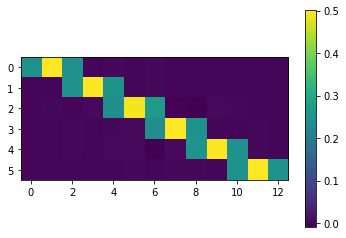

In [11]:
plt.imshow(GLOBALR)
plt.colorbar()

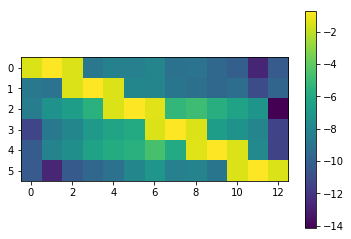

In [12]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

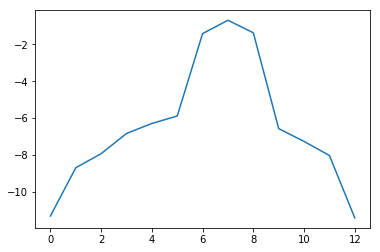

In [13]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
11.027852202264166
L2 norm: 
1.2338468109915928
H1 norm: 
8.126118148335626
Energy norm: 
0.9189876835220138
L2 norm: 
1.7449228939951034
H1 norm: 
0.9543641765736126
0.2668855080480741


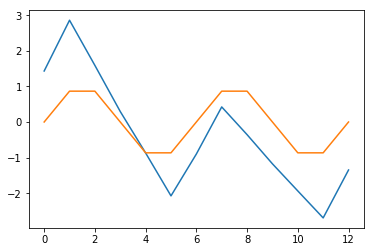

In [34]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)

Energy norm: 
64.13776864382129
L2 norm: 
7.55150170014629
H1 norm: 
43.84642877435839
Energy norm: 
5.455884474276271
L2 norm: 
10.679436120630367
H1 norm: 
5.255752540410707
0.1008287071386727


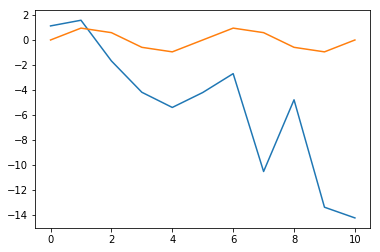

In [29]:
outputsize = np.size(LOCALR,0)
inputsize = np.size(LOCALR,1)
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
h = 1/(inputsize-1)
H = 1/(outputsize-1)
LOCALA = np.zeros([outputsize,outputsize])
for i in range(outputsize):
    for j in range(outputsize):
        basisi = LOCALR[i][:]
        basisj = LOCALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        LOCALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
LOCALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = LOCALR[j][:]
        LOCALF[j][0] = (np.sum(F*basisj))*(H)
        
LOCALU = np.linalg.solve(LOCALA,LOCALF)
LocalU = np.zeros([inputsize,1])
for i in range(outputsize):
    LocalU = LocalU + LOCALU[i]*LOCALR[i][:].reshape([inputsize,1])
    
deltaU = LocalU - Urealfine    

Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)


print(current_rho)

plt.plot(LocalU)
plt.plot(Urealfine)